# Cardio Dataset

This notebook aims at providing an example on how to change the columns variable type and data type and its impact on the fidelity.

Environment configuration:

In [30]:
import os
import sys
import numpy as np
from pathlib import Path

import pandas as pd
from numpy.random import random, choice
import matplotlib.pyplot as plt

from ydata.platform.datasources import DataSources

from ydata.synthesizers.regular.model import RegularSynthesizer
from ydata.metadata import Metadata
from ydata.dataset import Dataset
from ydata.utils.data_types import DataType, VariableType
from ydata.dataset.dataset_type import DatasetType

In [46]:
#Getting the list of the UI available datasources
my_datasources = DataSources.list()
print(my_datasources)

[FileDataSource(uid=276fb09c-047a-4ab3-ae33-0becc62b5680, data_type=DataType.TABULAR, file_type=FileType.CSV, path=data.csv), AzureBlobDataSource(uid=38d7c5a5-f561-4940-8a53-a60f2aae72e9, data_type=DataType.TABULAR, file_type=FileType.CSV, path=abfs://census/data.csv), GoogleCloudStorageDataSource(uid=3e1e1dd0-a19d-4755-977a-ecbcdfd18916, data_type=DataType.TIMESERIES, file_type=FileType.CSV, path=gs://ydata_testdata/timeseries/berka/data.csv), GoogleCloudStorageDataSource(uid=54a8c49e-b979-4db4-a526-4ad0c348bb52, data_type=DataType.TABULAR, file_type=FileType.CSV, path=gs://ydata_testdata/tabular/cardio/data.csv), AWSS3DataSource(uid=54c5c6e8-6548-46b1-93ba-050ff12582af, data_type=DataType.TABULAR, region=eu-central-1, file_type=FileType.CSV, path=s3://ydata-dev/regular/credit_fraud/data.csv), AzureBlobDataSource(uid=60398277-19d8-4378-ac27-2e1f5dea9635, data_type=DataType.TABULAR, file_type=FileType.CSV, path=abfs://diamonds/data.csv), GoogleCloudStorageDataSource(uid=952e1bbe-f630-4

In [31]:
# Reading Dataset from the UI
datasource = DataSources.get('{insert-datasource-id}')
original = datasource.read()

In [32]:
original.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
idx,,,,,,,,,,,,,
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


Let us calculate the metadata and print the summary.

In [33]:
m = Metadata(original)

Cardio is a public dataset on Cardiovascular Disease available from Kaggle: https://www.kaggle.com/datasets/sulianova/cardiovascular-disease-dataset

The dataset description informs us of several small mistakes from the data inference:
1. the variables type of `smoke`, `alco`, `active` and `cardio` is `bool` instead of `int`
2. the data type for `height`, `weight`, `ap_hi` and `ap_lo` should be numerical instead of categorical
3. the variable type of `weight` is indeed `float` but a quick look reveals that it should be `int` as there is no decimal used for any value.

The point (1) is not really an issue as it is just a representation issue and we can always map to a boolean at any time. However, points (2) is an issue because for categorical variables, the support of the synthetic data will be limited to the one in the original dataset. For point (3), using the best variable type will return better quality synthetic data.

In [34]:
print(m)

Metadata Summary 
 
Dataset type: TABULAR
Dataset attributes: 
Number of columns: 13
% of duplicate rows: 0
Target column: 

Column detail: 
         Column    Data type Variable type
0            id    numerical           int
1           age    numerical           int
2        gender  categorical           int
3        height  categorical           int
4        weight  categorical         float
5         ap_hi  categorical           int
6         ap_lo  categorical           int
7   cholesterol  categorical           int
8          gluc  categorical           int
9         smoke  categorical           int
10         alco  categorical           int
11       active  categorical           int
12       cardio  categorical           int

Warnings: 
                   Warning                         Columns
0  WarningType.CARDINALITY  [height, weight, ap_hi, ap_lo]



Let us create a new metadata object and adjust accordingly the variable types.

In [35]:
#First let's change the the variable types that are not correct
# to do so, this must be done at the level of the Dataset
original.astype(column='weight', 
                vartype=VariableType.INT)

In [ ]:
original.schema

In [38]:
#recompute the metadata after the variable type change
m2 = Metadata(original)

In [39]:
print(m2)

Metadata Summary 
 
Dataset type: TABULAR
Dataset attributes: 
Number of columns: 13
% of duplicate rows: 0
Target column: 

Column detail: 
         Column    Data type Variable type
0            id    numerical           int
1           age    numerical           int
2        gender  categorical           int
3        height  categorical           int
4        weight  categorical           int
5         ap_hi  categorical           int
6         ap_lo  categorical           int
7   cholesterol  categorical           int
8          gluc  categorical           int
9         smoke  categorical           int
10         alco  categorical           int
11       active  categorical           int
12       cardio  categorical           int

Warnings: 
                   Warning                         Columns
0  WarningType.CARDINALITY  [height, weight, ap_hi, ap_lo]



In [40]:
#Change the data types that are not aligned with the expectations
m2.columns = {
              'height': 'numerical',
              'weight': 'numerical',
              'ap_hi': 'numerical',
              'ap_lo': 'numerical',
             }

In [20]:
print(m2)

Metadata Summary 
 
Dataset type: TABULAR
Dataset attributes: 
Number of columns: 13
% of duplicate rows: 0
Target column: 

Column detail: 
         Column    Data type Variable type
0            id    numerical           int
1           age    numerical           int
2        gender  categorical           int
3        height    numerical           int
4        weight    numerical         float
5         ap_hi    numerical           int
6         ap_lo    numerical           int
7   cholesterol  categorical           int
8          gluc  categorical           int
9         smoke  categorical           int
10         alco  categorical           int
11       active  categorical           int
12       cardio  categorical           int

Warnings: 
                Warning                         Columns
0  WarningType.SKEWNESS  [height, weight, ap_hi, ap_lo]



## Train and generate a sample

To compare the influence, we will train one synthesizer using each version of the metadata and run the different metrics.

In [42]:
synth_1 = RegularSynthesizer()
synth_1.fit(original, metadata=m)

INFO: 2022-08-03 05:08:16,590 [SYNTHESIZER] - Number columns considered for synth: 13
INFO: 2022-08-03 05:08:22,878 [SYNTHESIZER] - Starting the synthetic data modeling process over 2x1 blocks.
INFO: 2022-08-03 05:08:22,879 [SYNTHESIZER] - Generating pipeline for segment (-0.001, 28041.5]
INFO: 2022-08-03 05:08:22,884 [SYNTHESIZER] - Preprocess segment
INFO: 2022-08-03 05:08:22,887 [SYNTHESIZER] - Synthesizer init.
INFO: 2022-08-03 05:08:22,888 [SYNTHESIZER] - Processing the data prior fitting the synthesizer.
INFO: 2022-08-03 05:08:29,822 [SYNTHESIZER] - Generating pipeline for segment (28041.5, 56083.0]
INFO: 2022-08-03 05:08:29,829 [SYNTHESIZER] - Preprocess segment
INFO: 2022-08-03 05:08:29,832 [SYNTHESIZER] - Synthesizer init.
INFO: 2022-08-03 05:08:29,834 [SYNTHESIZER] - Processing the data prior fitting the synthesizer.


In [10]:
synth_2 = RegularSynthesizer()
synth_2.fit(original, metadata=m2)

INFO: 2022-08-02 13:30:00,704 [SYNTHESIZER] - Number columns considered for synth: 13
INFO: 2022-08-02 13:30:13,166 [SYNTHESIZER] - Starting the synthetic data modeling process over 2x1 blocks.
INFO: 2022-08-02 13:30:13,170 [SYNTHESIZER] - Generating pipeline for segment (-0.001, 28031.0]
INFO: 2022-08-02 13:30:13,182 [SYNTHESIZER] - Preprocess segment
INFO: 2022-08-02 13:30:13,201 [SYNTHESIZER] - Synthesizer init.
INFO: 2022-08-02 13:30:13,203 [SYNTHESIZER] - Processing the data prior fitting the synthesizer.
INFO: 2022-08-02 13:30:36,442 [SYNTHESIZER] - Generating pipeline for segment (28031.0, 56062.0]
INFO: 2022-08-02 13:30:36,456 [SYNTHESIZER] - Preprocess segment
INFO: 2022-08-02 13:30:36,469 [SYNTHESIZER] - Synthesizer init.
INFO: 2022-08-02 13:30:36,471 [SYNTHESIZER] - Processing the data prior fitting the synthesizer.


In [11]:
sample_1 = synth_1.sample(n_samples=len(original))
sample_1_df = sample_1.to_pandas()

INFO: 2022-08-02 13:30:56,326 [SYNTHESIZER] - Start generating model samples.
INFO: 2022-08-02 13:30:56,331 [SYNTHESIZER] - Sample segment (-0.001, 27996.0]
INFO: 2022-08-02 13:31:03,583 [SYNTHESIZER] - Sample segment (27996.0, 55992.0]


In [12]:
sample_2 = synth_2.sample(n_samples=int(len(original)))
sample_2_df = sample_2.to_pandas()

INFO: 2022-08-02 13:31:12,717 [SYNTHESIZER] - Start generating model samples.
INFO: 2022-08-02 13:31:12,719 [SYNTHESIZER] - Sample segment (-0.001, 28031.0]
INFO: 2022-08-02 13:31:19,434 [SYNTHESIZER] - Sample segment (28031.0, 56062.0]


In [13]:
sample_1_df

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,84395,21273,1,165,92.0,120,80,1,1,0,0,1,0
1,18162,22123,1,156,58.0,130,70,1,1,0,0,0,1
2,97586,19820,2,163,84.0,150,90,1,1,0,0,1,1
3,14587,19841,1,165,98.0,110,80,2,1,0,0,1,0
4,61588,20269,1,163,76.0,120,70,3,3,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,89226,18778,1,164,64.0,130,80,1,1,0,0,1,0
69996,82233,17508,2,171,81.0,130,80,1,1,1,0,1,0
69997,77143,21989,2,181,82.0,135,80,1,1,0,1,1,1
69998,91351,16929,1,154,73.0,110,80,1,1,0,0,0,0


In [14]:
sample_2_df

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,29346,19857,1,163,66,150,90,1,1,0,0,1,1
1,61972,20509,1,160,85,110,80,1,1,0,0,1,0
2,77565,14554,1,171,64,120,80,1,1,0,0,0,0
3,35567,17263,1,170,93,130,85,1,1,0,0,1,0
4,75415,22597,2,162,76,130,90,3,1,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,84641,14840,2,180,80,120,70,1,1,0,0,1,0
69996,17971,20545,1,162,62,120,70,1,1,0,0,1,1
69997,10404,21938,1,153,54,120,80,1,1,0,0,1,1
69998,9456,16001,2,179,76,130,90,1,1,0,0,1,1


In [15]:
original_df = original.to_pandas()
original_df

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,99993,19240,2,168,76.0,120,80,1,1,1,0,1,0
69996,99995,22601,1,158,126.0,140,90,2,2,0,0,1,1
69997,99996,19066,2,183,105.0,180,90,3,1,0,1,0,1
69998,99998,22431,1,163,72.0,135,80,1,2,0,0,0,1


# Fidelity

In addition to the reports generated by the platform, let us explore manually the fidelity.

## Correlation

There are two different aspects to evaluate:

1. The correlation between a column X of the original data and its counterpart in the synthetic dataset must be high.
2. The correlation between columns X and Y of the orignal data must be preserved in the synthetic dataset.

### Correlation matrix

Let us calculate the correlation matrices which accounts for the dependencies between the columns.

In [16]:
original_df = original.to_pandas()
corr_original = original_df.corr()
corr_original.style.background_gradient(cmap='coolwarm', vmin=0, vmax=1)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,1.000000,0.003457,0.003502,-0.003038,-0.001830,0.003356,-0.002529,0.006106,0.002467,-0.003699,0.001210,0.003755,0.003799
age,0.003457,1.000000,-0.022811,-0.081515,0.053684,0.020764,0.017647,0.154424,0.098703,-0.047633,-0.029723,-0.009927,0.238159
gender,0.003502,-0.022811,1.000000,0.499033,0.155406,0.006005,0.015254,-0.035821,-0.020491,0.338135,0.170966,0.005866,0.008109
height,-0.003038,-0.081515,0.499033,1.000000,0.290968,0.005488,0.006150,-0.050226,-0.018595,0.187989,0.094419,-0.006570,-0.010821
weight,-0.001830,0.053684,0.155406,0.290968,1.000000,0.030702,0.043710,0.141768,0.106857,0.067780,0.067113,-0.016867,0.181660
ap_hi,0.003356,0.020764,0.006005,0.005488,0.030702,1.000000,0.016086,0.023778,0.011841,-0.000922,0.001408,-0.000033,0.054475
ap_lo,-0.002529,0.017647,0.015254,0.006150,0.043710,0.016086,1.000000,0.024019,0.010806,0.005186,0.010601,0.004780,0.065719
cholesterol,0.006106,0.154424,-0.035821,-0.050226,0.141768,0.023778,0.024019,1.000000,0.451578,0.010354,0.035760,0.009911,0.221147
gluc,0.002467,0.098703,-0.020491,-0.018595,0.106857,0.011841,0.010806,0.451578,1.000000,-0.004756,0.011246,-0.006770,0.089307
smoke,-0.003699,-0.047633,0.338135,0.187989,0.067780,-0.000922,0.005186,0.010354,-0.004756,1.000000,0.340094,0.025858,-0.015486


In [17]:
corr_synt_1 = sample_1_df.corr()
corr_synt_1.style.background_gradient(cmap='coolwarm', vmin=0, vmax=1)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,1.000000,-0.001816,0.004501,-0.001580,0.000822,0.004054,-0.010422,0.002884,-0.010019,-0.004917,-0.004559,-0.005118,-0.002694
age,-0.001816,1.000000,-0.028028,-0.080317,0.053634,0.027117,0.019793,0.154163,0.095503,-0.051305,-0.037279,-0.008364,0.224621
gender,0.004501,-0.028028,1.000000,0.496003,0.169171,0.007880,0.006063,-0.023693,-0.007684,0.338810,0.172582,-0.001183,0.009402
height,-0.001580,-0.080317,0.496003,1.000000,0.285210,0.006063,0.005703,-0.045494,-0.017107,0.191135,0.091250,-0.003771,-0.003264
weight,0.000822,0.053634,0.169171,0.285210,1.000000,0.035667,0.038719,0.144402,0.100576,0.075719,0.076053,-0.024522,0.182912
ap_hi,0.004054,0.027117,0.007880,0.006063,0.035667,1.000000,0.019217,0.026281,0.015715,0.006322,0.003584,-0.000162,0.055799
ap_lo,-0.010422,0.019793,0.006063,0.005703,0.038719,0.019217,1.000000,0.034299,0.017009,0.011450,0.020728,-0.000438,0.061210
cholesterol,0.002884,0.154163,-0.023693,-0.045494,0.144402,0.026281,0.034299,1.000000,0.445938,0.012389,0.042969,-0.000636,0.211068
gluc,-0.010019,0.095503,-0.007684,-0.017107,0.100576,0.015715,0.017009,0.445938,1.000000,0.008624,0.030713,-0.007000,0.081143
smoke,-0.004917,-0.051305,0.338810,0.191135,0.075719,0.006322,0.011450,0.012389,0.008624,1.000000,0.338659,0.027692,-0.010079


In [18]:
corr_synt_2 = sample_2_df.corr()
corr_synt_2.style.background_gradient(cmap='coolwarm', vmin=0, vmax=1)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,1.000000,0.003952,0.001757,0.000859,-0.000803,-0.002260,-0.010650,0.002151,-0.005178,-0.005829,-0.012049,-0.001477,0.011479
age,0.003952,1.000000,-0.025855,-0.081933,0.054525,0.016645,0.021477,0.150884,0.092397,-0.048953,-0.017754,-0.010469,0.235364
gender,0.001757,-0.025855,1.000000,0.493835,0.160685,0.000116,0.017592,-0.030216,-0.004112,0.330422,0.158597,0.012877,0.008575
height,0.000859,-0.081933,0.493835,1.000000,0.290538,-0.004473,0.014343,-0.048799,-0.016288,0.188205,0.079156,0.005241,-0.002939
weight,-0.000803,0.054525,0.160685,0.290538,1.000000,0.024079,0.064194,0.142204,0.107054,0.070503,0.066959,-0.014930,0.174890
ap_hi,-0.002260,0.016645,0.000116,-0.004473,0.024079,1.000000,0.030905,0.021745,0.004991,0.002814,0.000996,-0.003354,0.046496
ap_lo,-0.010650,0.021477,0.017592,0.014343,0.064194,0.030905,1.000000,0.040669,0.022347,0.020699,0.021625,0.004649,0.063206
cholesterol,0.002151,0.150884,-0.030216,-0.048799,0.142204,0.021745,0.040669,1.000000,0.434606,0.002769,0.043428,-0.007062,0.212254
gluc,-0.005178,0.092397,-0.004112,-0.016288,0.107054,0.004991,0.022347,0.434606,1.000000,0.003003,0.030517,-0.024105,0.077291
smoke,-0.005829,-0.048953,0.330422,0.188205,0.070503,0.002814,0.020699,0.002769,0.003003,1.000000,0.337828,0.030972,-0.006397


Now, we have two correlation matrices. They look pretty similar but we cannot just observe them to assess the quality.   
The idea is that if the two correlation matrices are similar, the Frobenius norm of the residuals should be 0.


In [19]:
### Froebenius norm of the residuals
corr_residual_1 = corr_original - corr_synt_1
corr_residual_1.style.background_gradient(cmap='coolwarm', vmin=0, vmax=1)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,0.000000,0.005272,-0.000999,-0.001458,-0.002652,-0.000698,0.007893,0.003223,0.012485,0.001218,0.005769,0.008873,0.006494
age,0.005272,0.000000,0.005218,-0.001198,0.000050,-0.006353,-0.002146,0.000261,0.003200,0.003673,0.007556,-0.001564,0.013538
gender,-0.000999,0.005218,0.000000,0.003030,-0.013766,-0.001875,0.009191,-0.012128,-0.012807,-0.000675,-0.001616,0.007049,-0.001292
height,-0.001458,-0.001198,0.003030,0.000000,0.005758,-0.000575,0.000447,-0.004732,-0.001487,-0.003146,0.003169,-0.002799,-0.007557
weight,-0.002652,0.000050,-0.013766,0.005758,0.000000,-0.004965,0.004990,-0.002634,0.006281,-0.007939,-0.008940,0.007655,-0.001252
ap_hi,-0.000698,-0.006353,-0.001875,-0.000575,-0.004965,0.000000,-0.003131,-0.002503,-0.003874,-0.007244,-0.002176,0.000129,-0.001324
ap_lo,0.007893,-0.002146,0.009191,0.000447,0.004990,-0.003131,0.000000,-0.010279,-0.006203,-0.006264,-0.010127,0.005218,0.004509
cholesterol,0.003223,0.000261,-0.012128,-0.004732,-0.002634,-0.002503,-0.010279,0.000000,0.005639,-0.002035,-0.007209,0.010547,0.010079
gluc,0.012485,0.003200,-0.012807,-0.001487,0.006281,-0.003874,-0.006203,0.005639,0.000000,-0.013380,-0.019467,0.000231,0.008164
smoke,0.001218,0.003673,-0.000675,-0.003146,-0.007939,-0.007244,-0.006264,-0.002035,-0.013380,0.000000,0.001434,-0.001834,-0.005407


The residual of the correlation matrix looks good. The summary indicator reflects this as well:

In [20]:
import scipy
norm_res = scipy.linalg.norm(corr_residual_1, ord='fro')
print(f"Frobenius norm of the correlation matrix residuals: {norm_res:.2f}")

Frobenius norm of the correlation matrix residuals: 0.08


In [21]:
### Froebenius norm of the residuals
corr_residual_2 = corr_original - corr_synt_2
corr_residual_2.style.background_gradient(cmap='coolwarm', vmin=0, vmax=1)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,0.000000,-0.000495,0.001745,-0.003897,-0.001027,0.005615,0.008121,0.003955,0.007645,0.002130,0.013259,0.005232,-0.007680
age,-0.000495,0.000000,0.003044,0.000417,-0.000840,0.004119,-0.003829,0.003539,0.006306,0.001321,-0.011969,0.000542,0.002795
gender,0.001745,0.003044,0.000000,0.005198,-0.005279,0.005889,-0.002338,-0.005605,-0.016379,0.007713,0.012370,-0.007012,-0.000466
height,-0.003897,0.000417,0.005198,0.000000,0.000430,0.009960,-0.008193,-0.001427,-0.002307,-0.000216,0.015262,-0.011810,-0.007882
weight,-0.001027,-0.000840,-0.005279,0.000430,0.000000,0.006623,-0.020484,-0.000436,-0.000196,-0.002723,0.000154,-0.001937,0.006770
ap_hi,0.005615,0.004119,0.005889,0.009960,0.006623,0.000000,-0.014819,0.002033,0.006850,-0.003736,0.000413,0.003321,0.007979
ap_lo,0.008121,-0.003829,-0.002338,-0.008193,-0.020484,-0.014819,0.000000,-0.016650,-0.011541,-0.015512,-0.011024,0.000131,0.002513
cholesterol,0.003955,0.003539,-0.005605,-0.001427,-0.000436,0.002033,-0.016650,0.000000,0.016972,0.007585,-0.007668,0.016973,0.008894
gluc,0.007645,0.006306,-0.016379,-0.002307,-0.000196,0.006850,-0.011541,0.016972,0.000000,-0.007760,-0.019271,0.017335,0.012015
smoke,0.002130,0.001321,0.007713,-0.000216,-0.002723,-0.003736,-0.015512,0.007585,-0.007760,0.000000,0.002266,-0.005114,-0.009089


In [22]:
import scipy
norm_res = scipy.linalg.norm(corr_residual_2, ord='fro')
print(f"Frobenius norm of the correlation matrix residuals: {norm_res:.2f}")

Frobenius norm of the correlation matrix residuals: 0.11


As we can see, the residuals are roughly similar but in case the datatype or variable type is far from the correct one, this might have a huge impact on the residuals.

## Histogram & Distributions

We now evaluate the quality of distributions.

### Marginal Distribution comparison

We plot below the marginal distribution for each column.
As expected, with the proper variable type and data types, the distribution for weight and height are better replicated. Same comment for ap_lo and ap_hi.

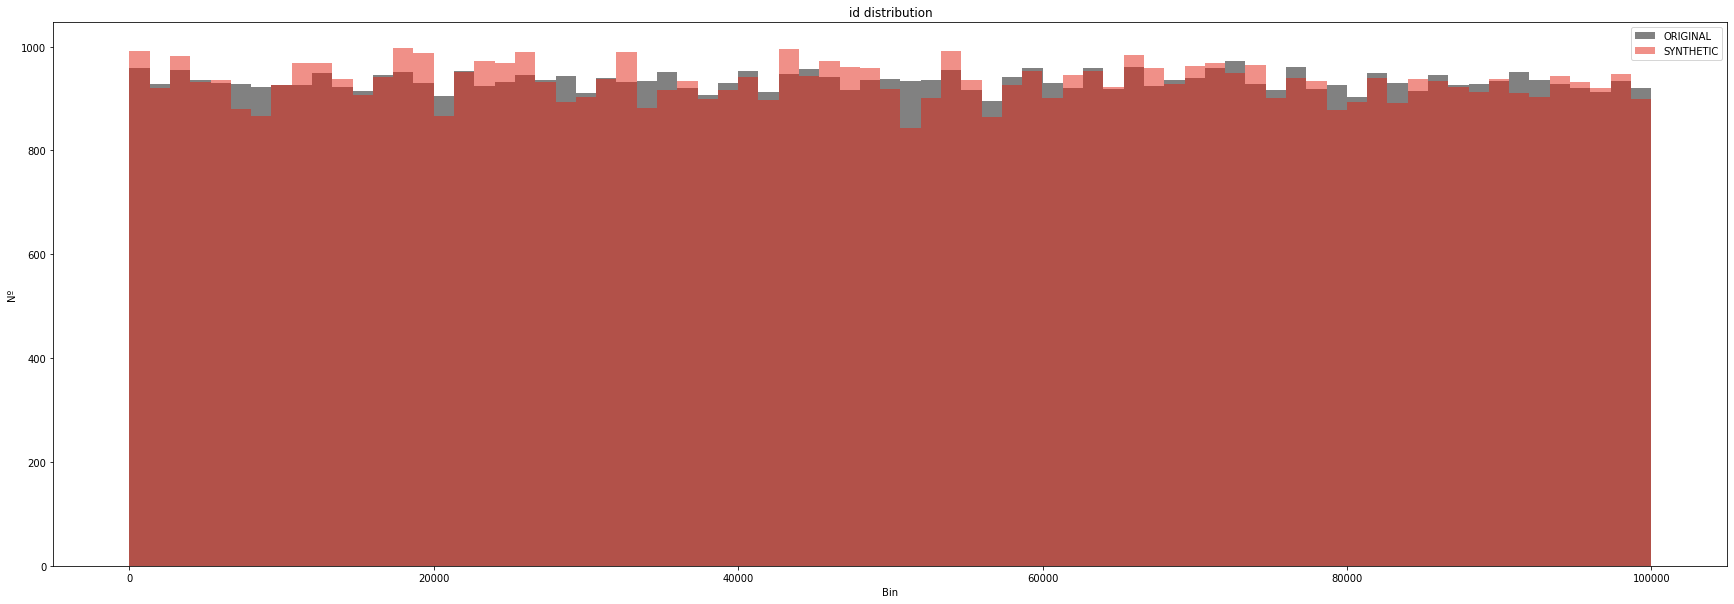

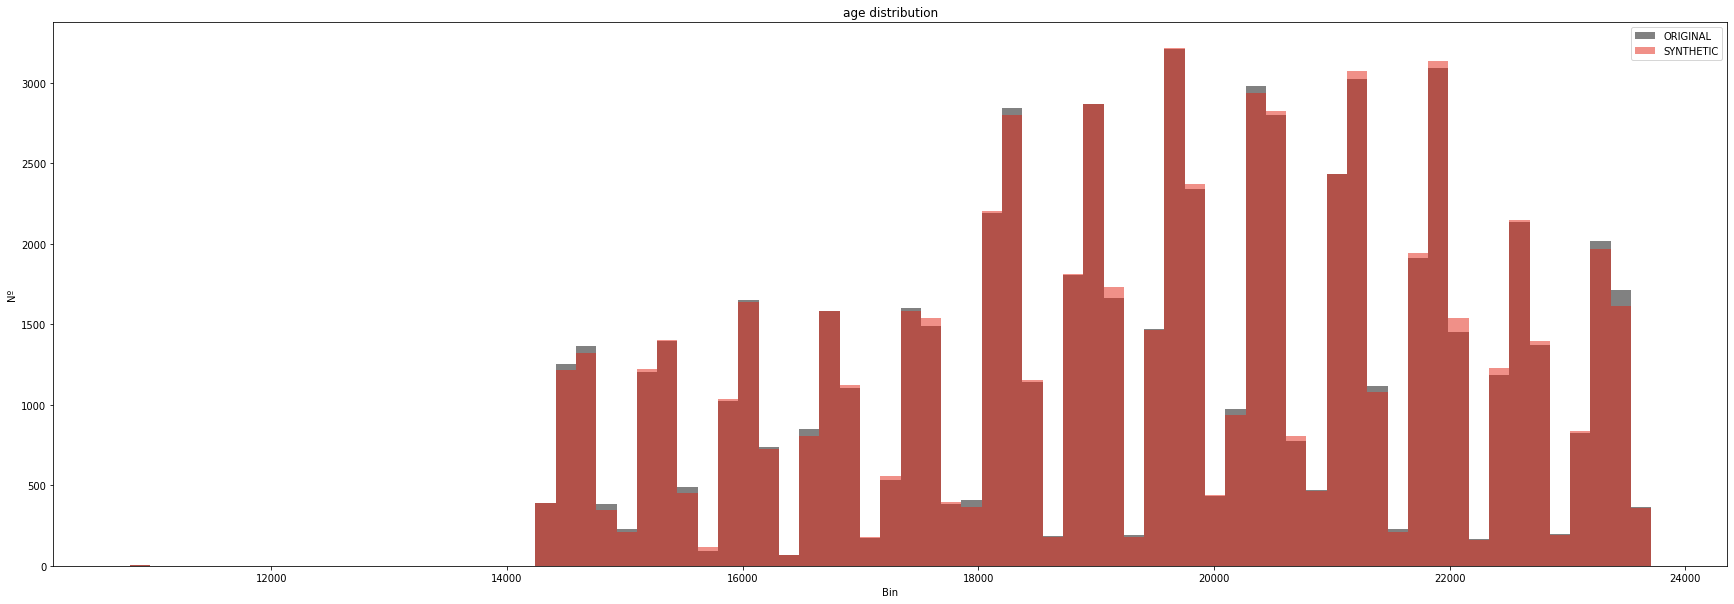

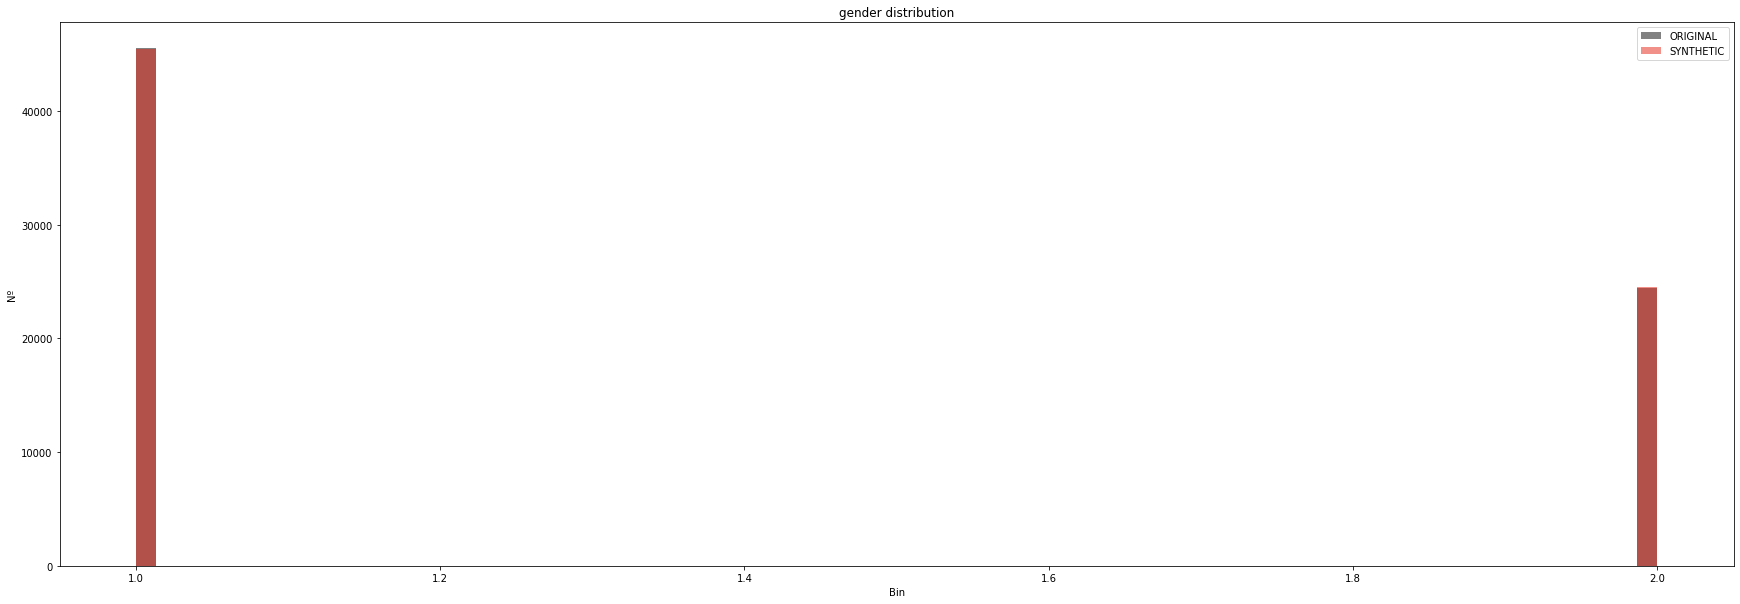

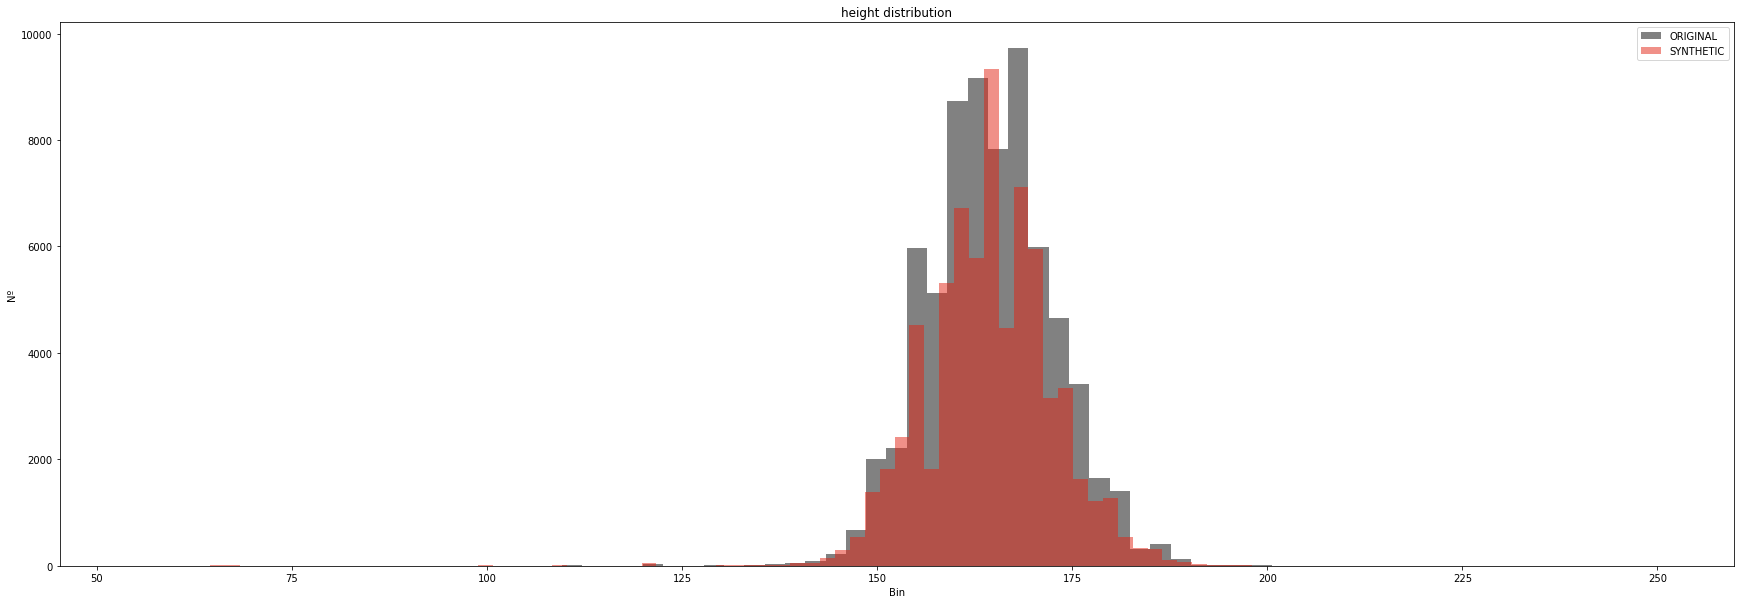

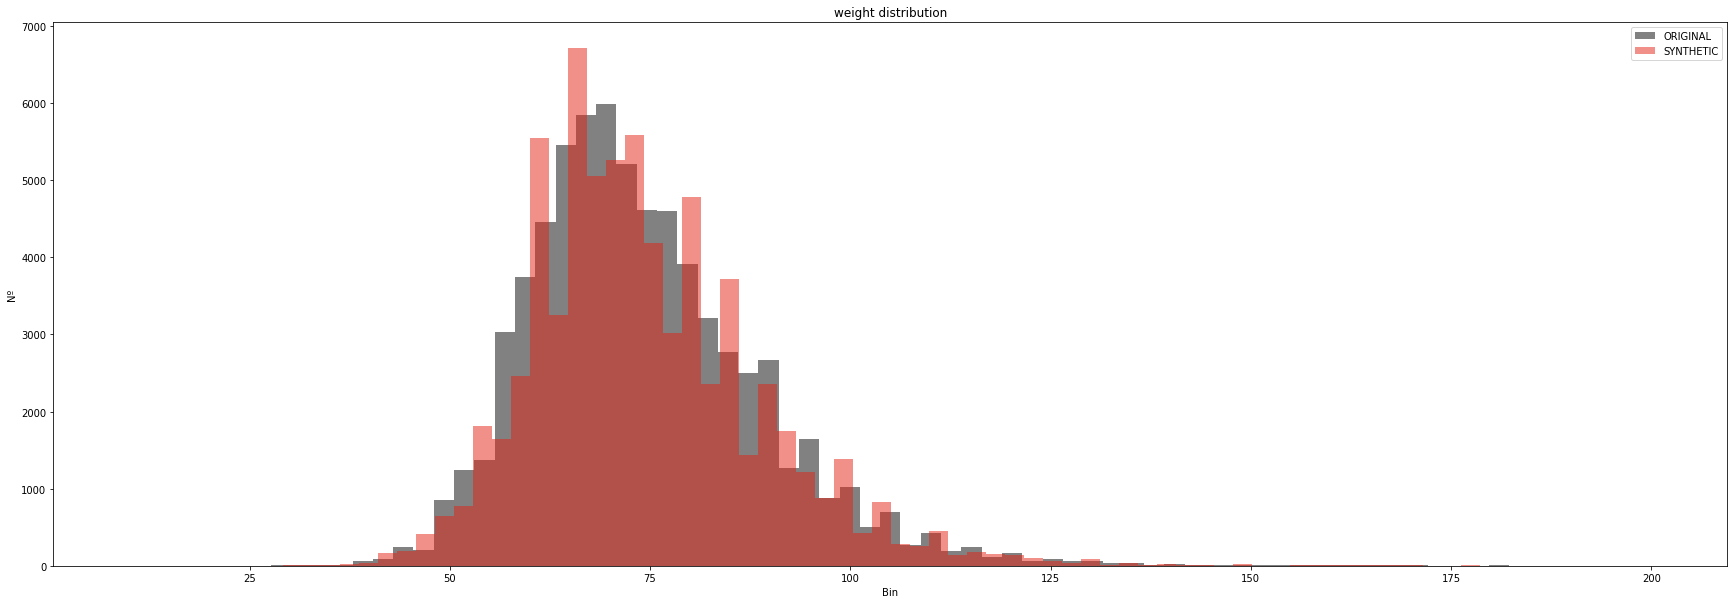

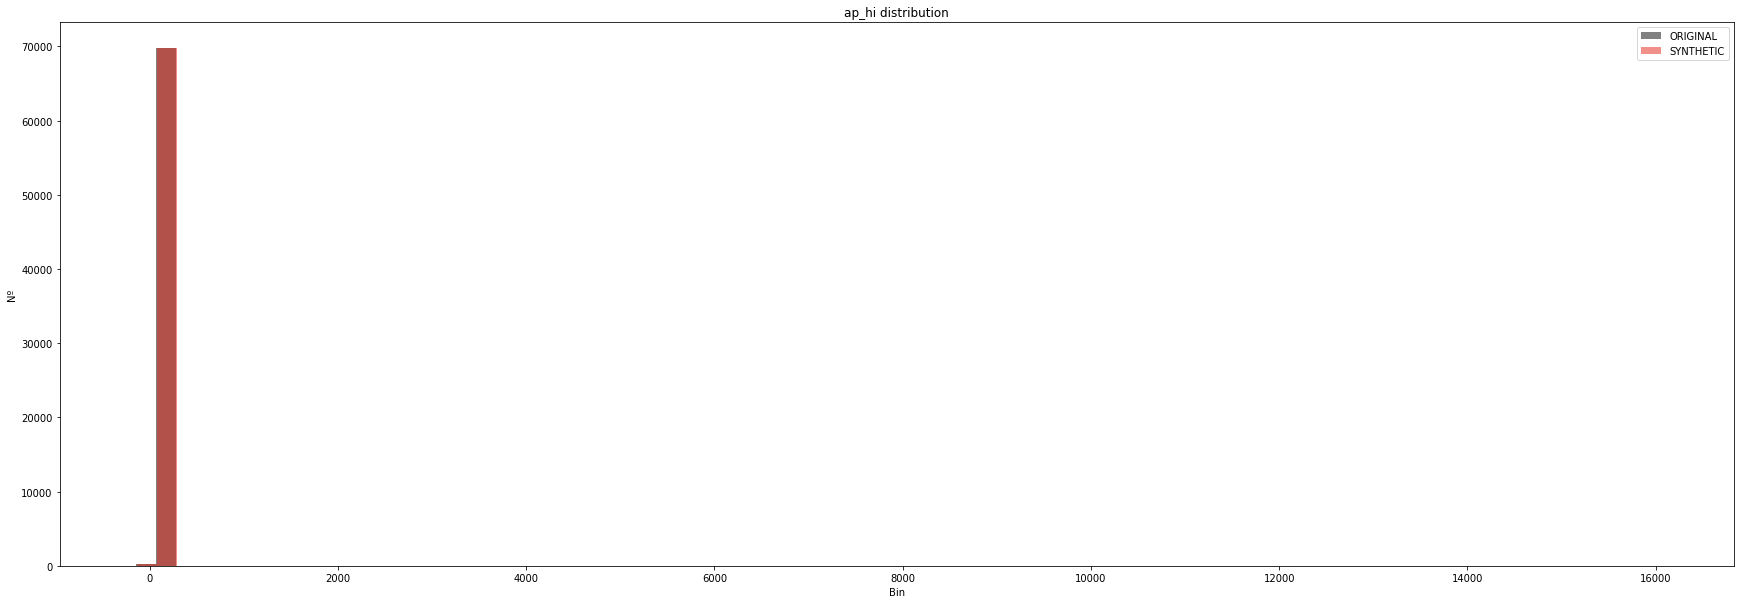

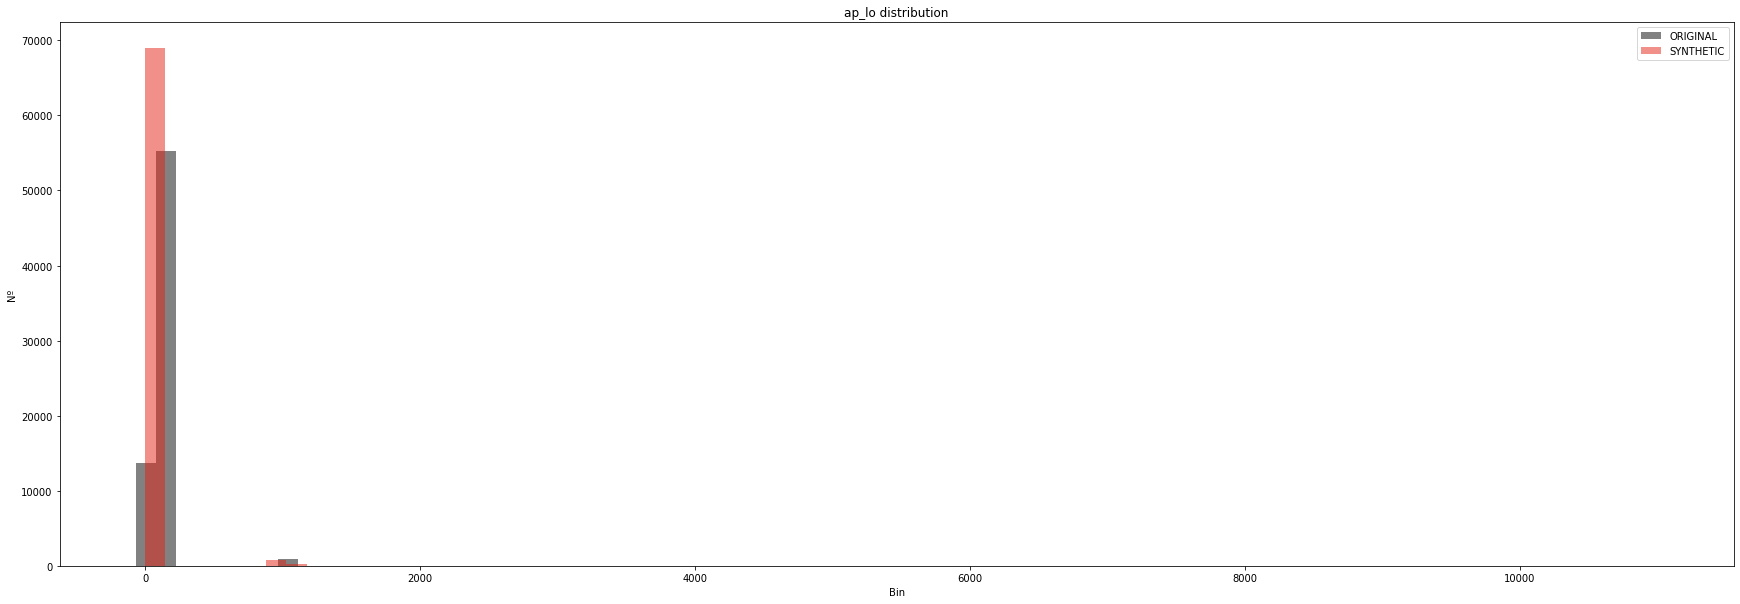

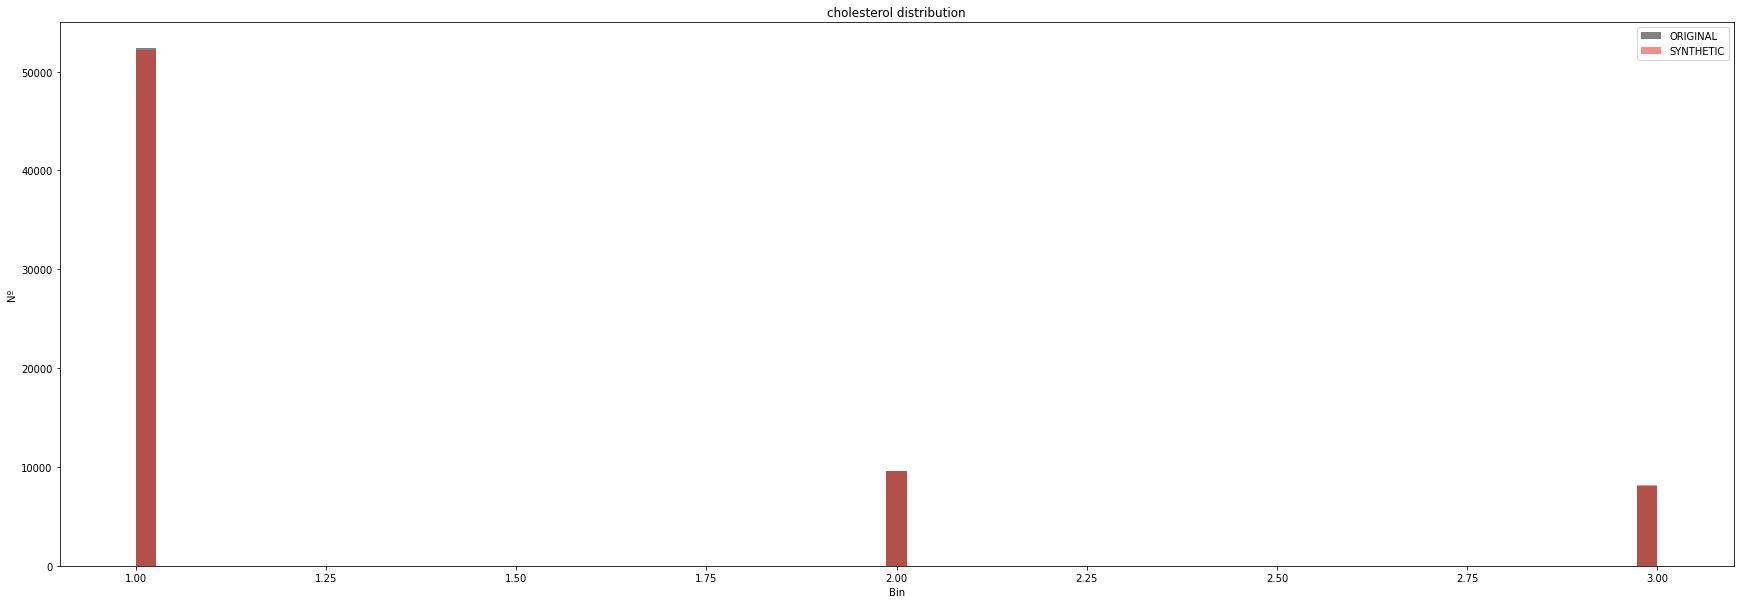

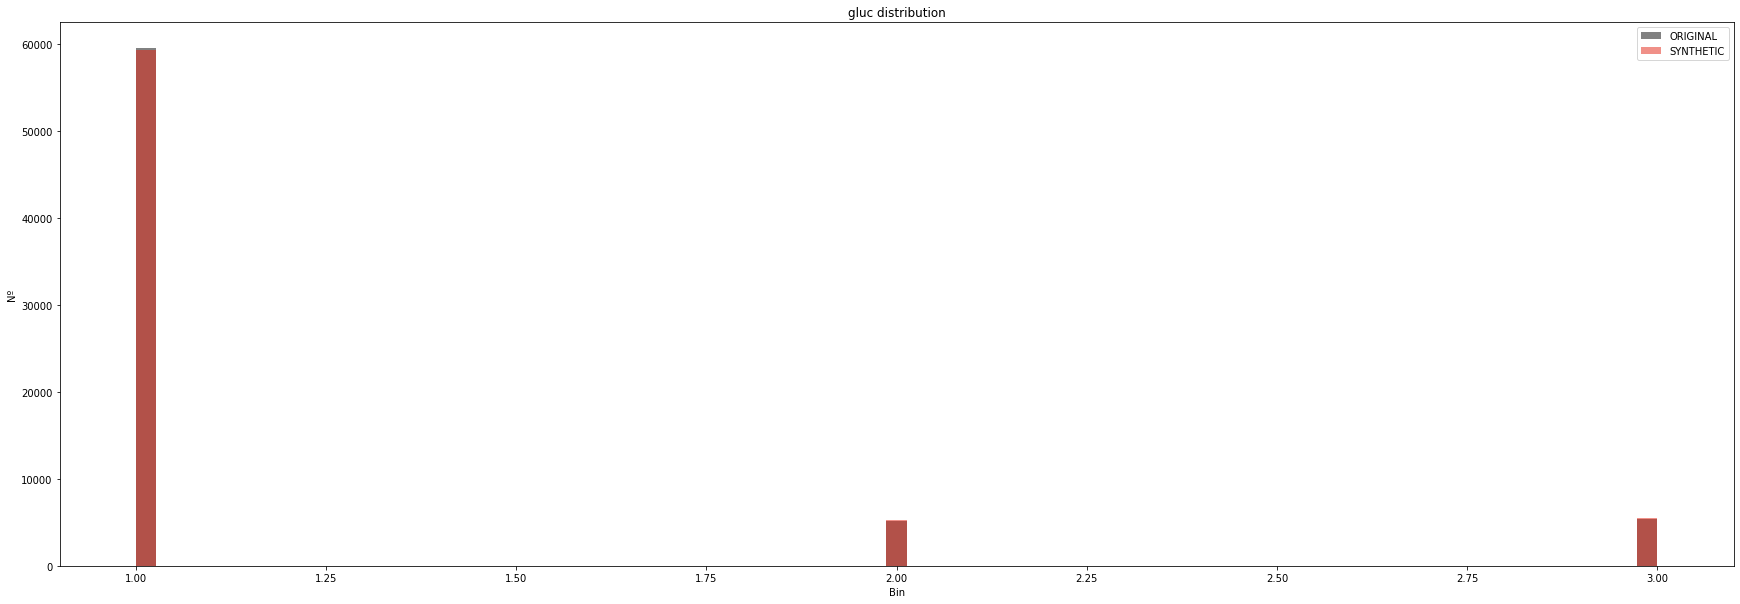

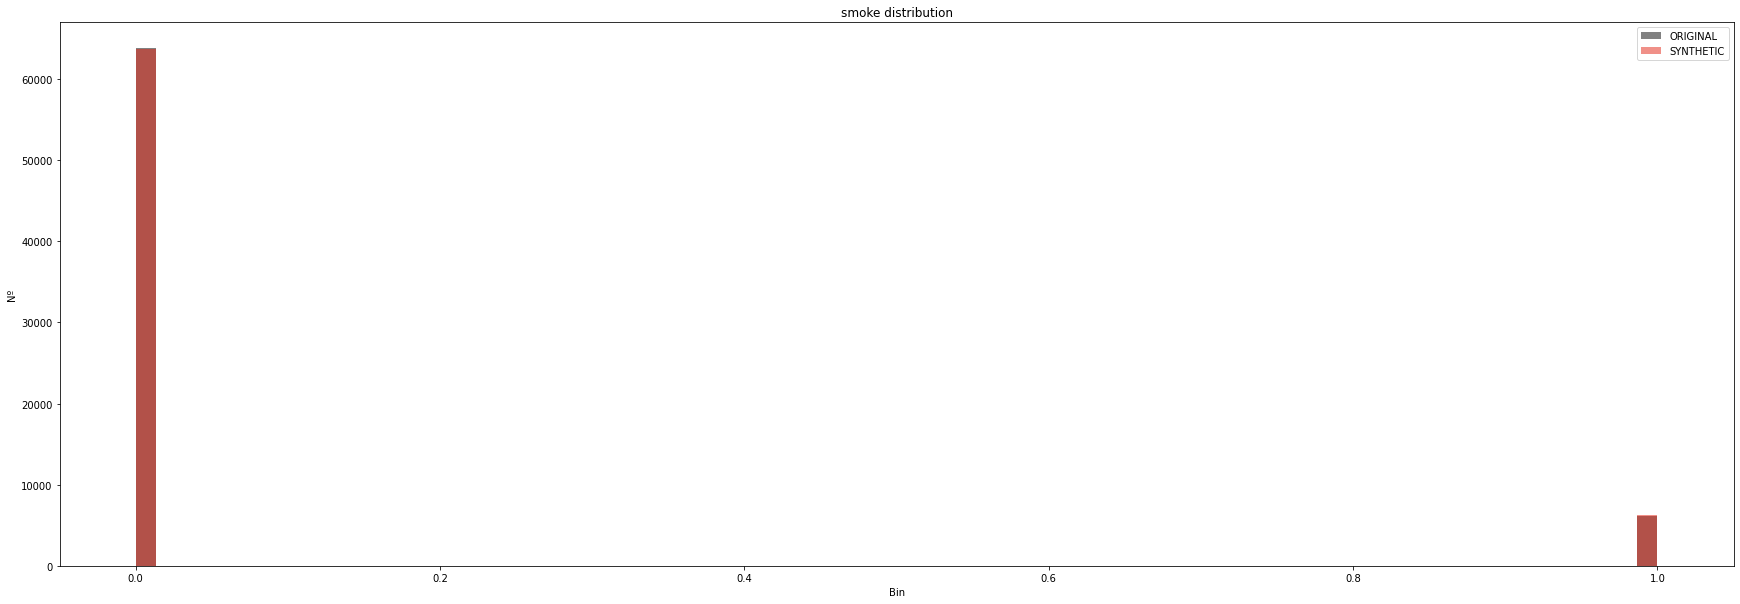

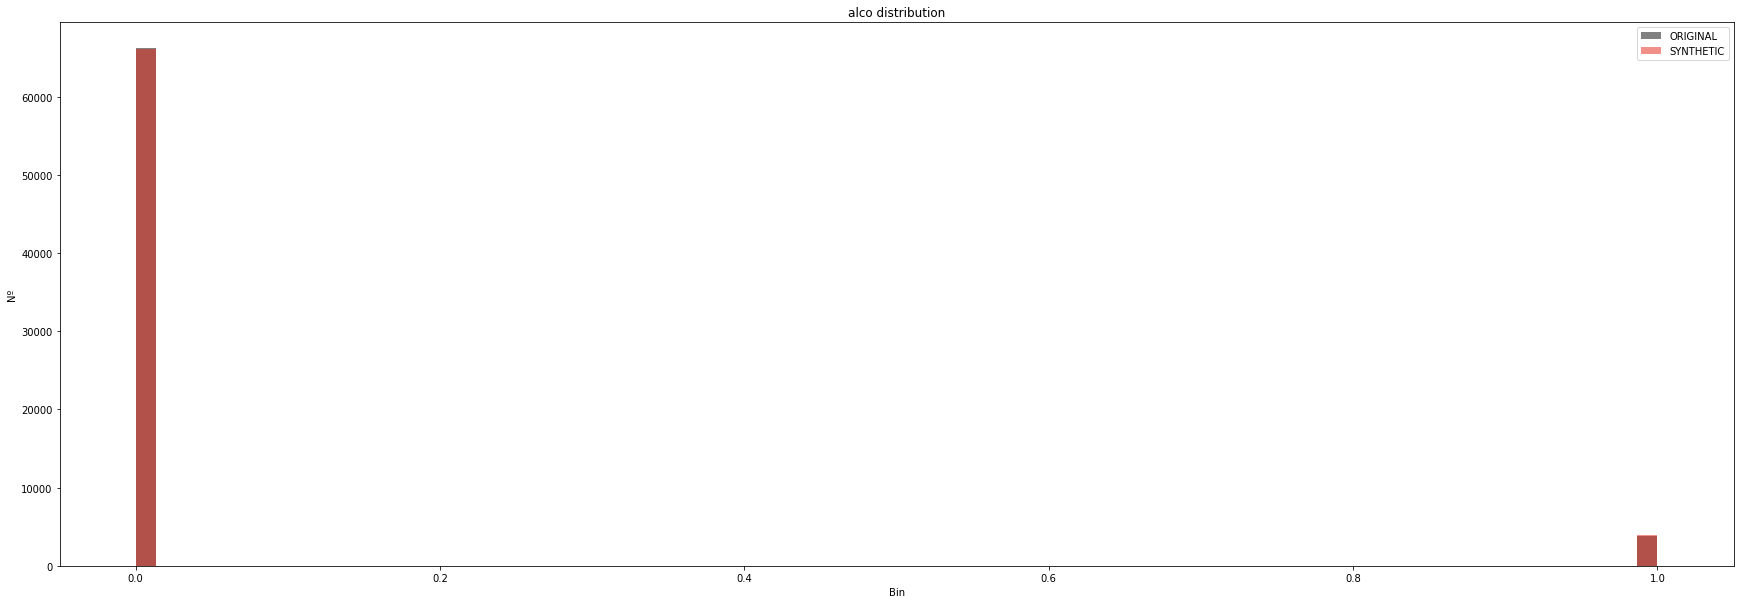

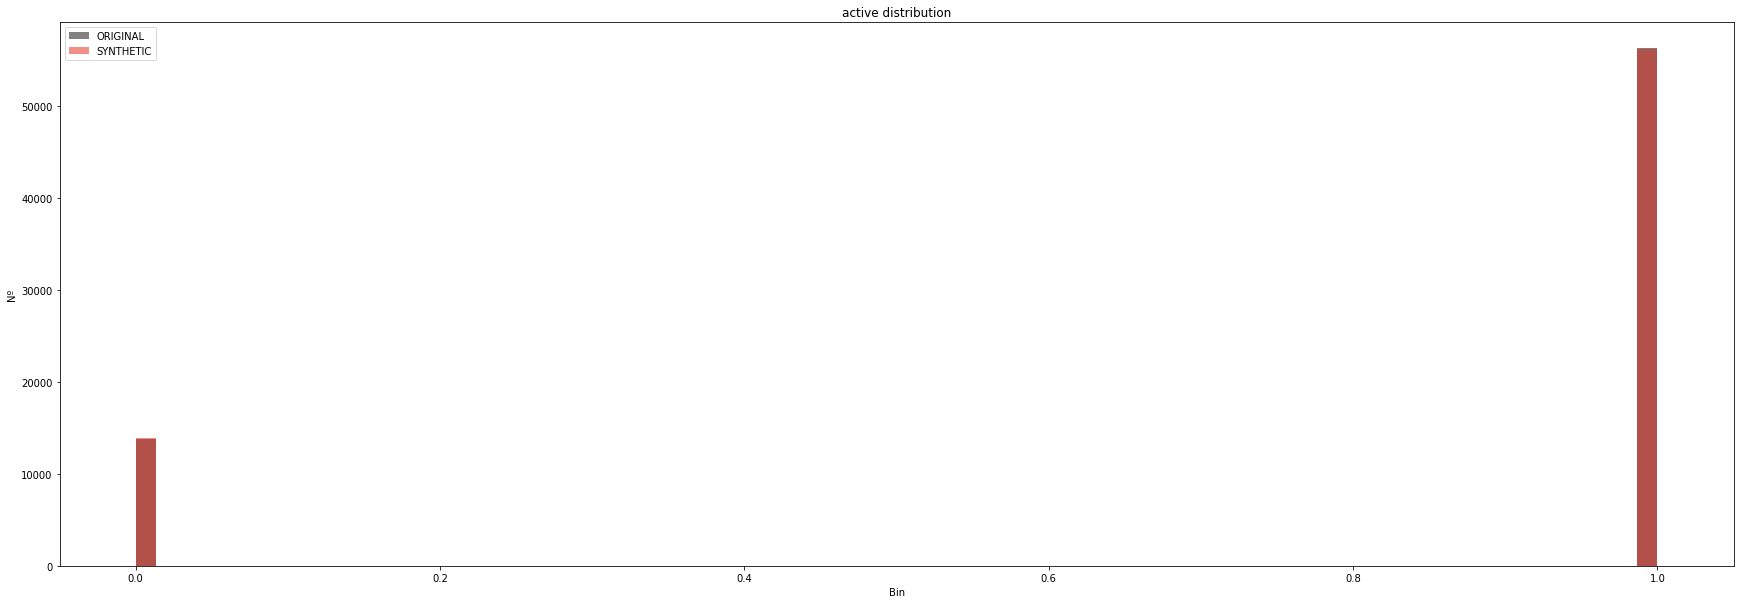

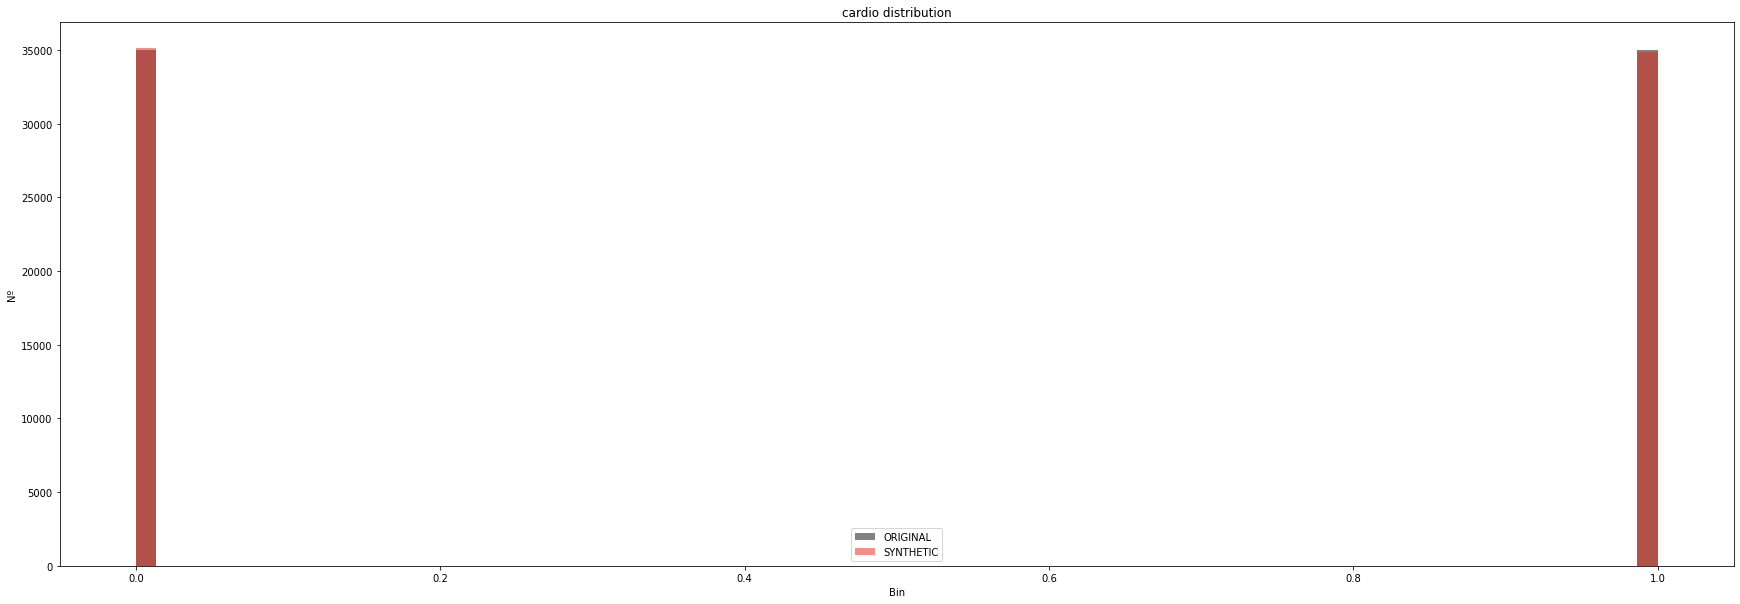

In [30]:
for c in sample_1_df.columns:
    plt.figure(figsize=[30, 10])
    plt.title(f"{c} distribution")
    original_df[c].hist(color="#040404", label="ORIGINAL", grid=False, bins=75, alpha=0.5)
    sample_1_df[c].hist(color="#E32212", label="SYNTHETIC", grid=False, bins=75, alpha=0.5)
    plt.xlabel("Bin")
    plt.ylabel("Nº")
    plt.legend()
    plt.show()

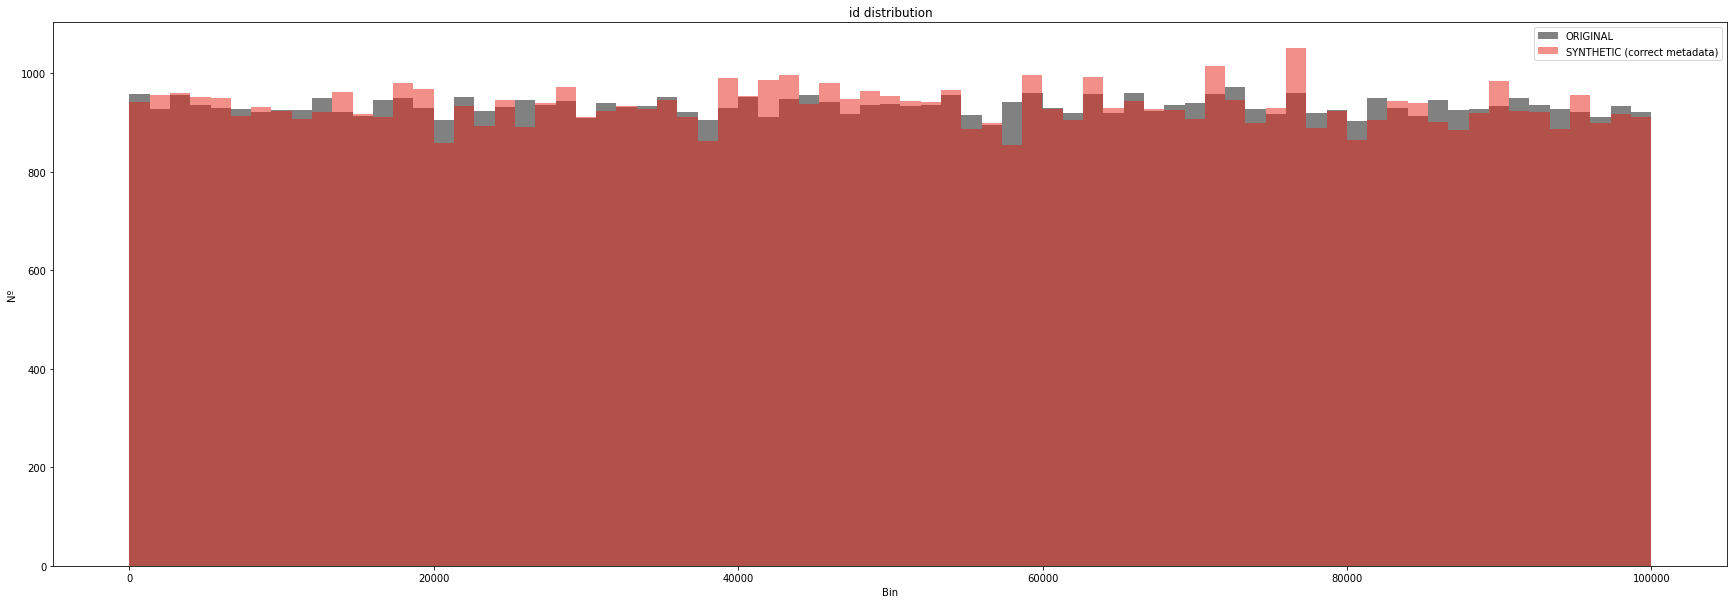

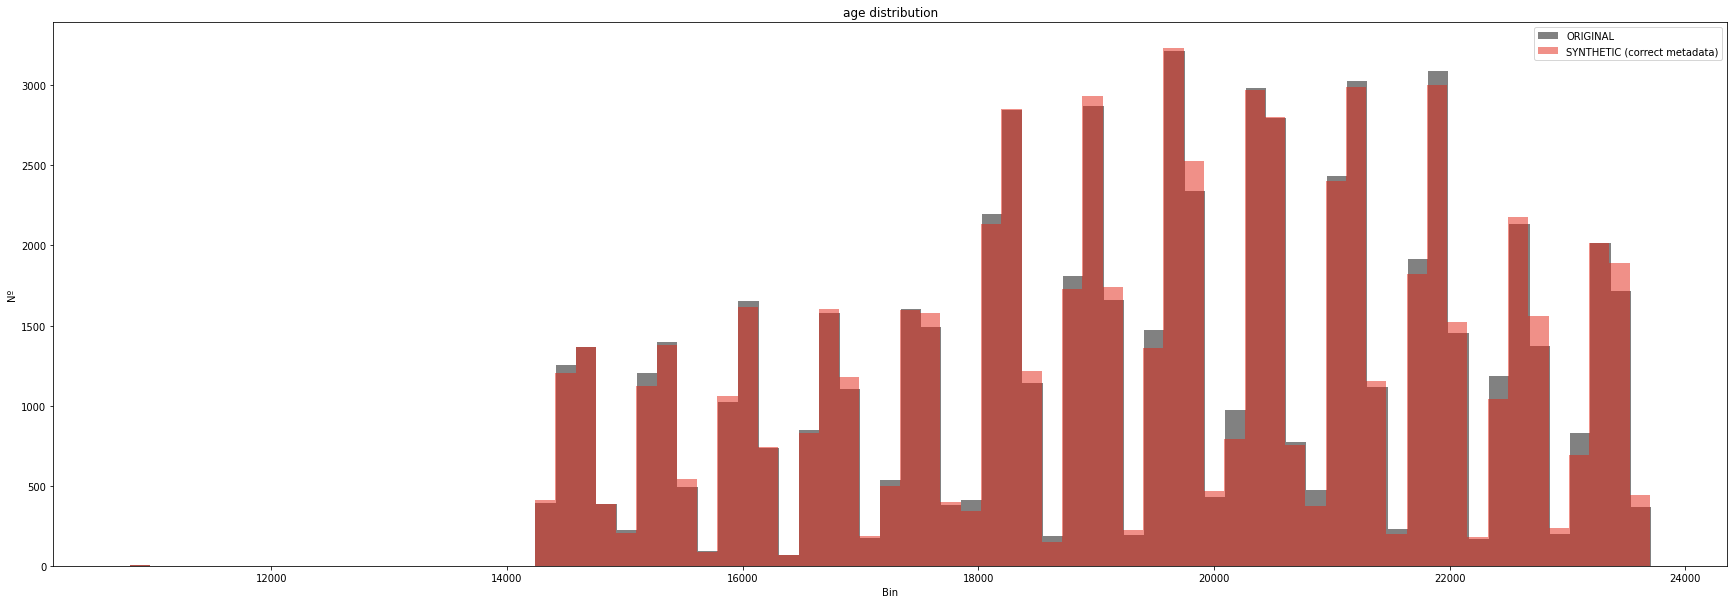

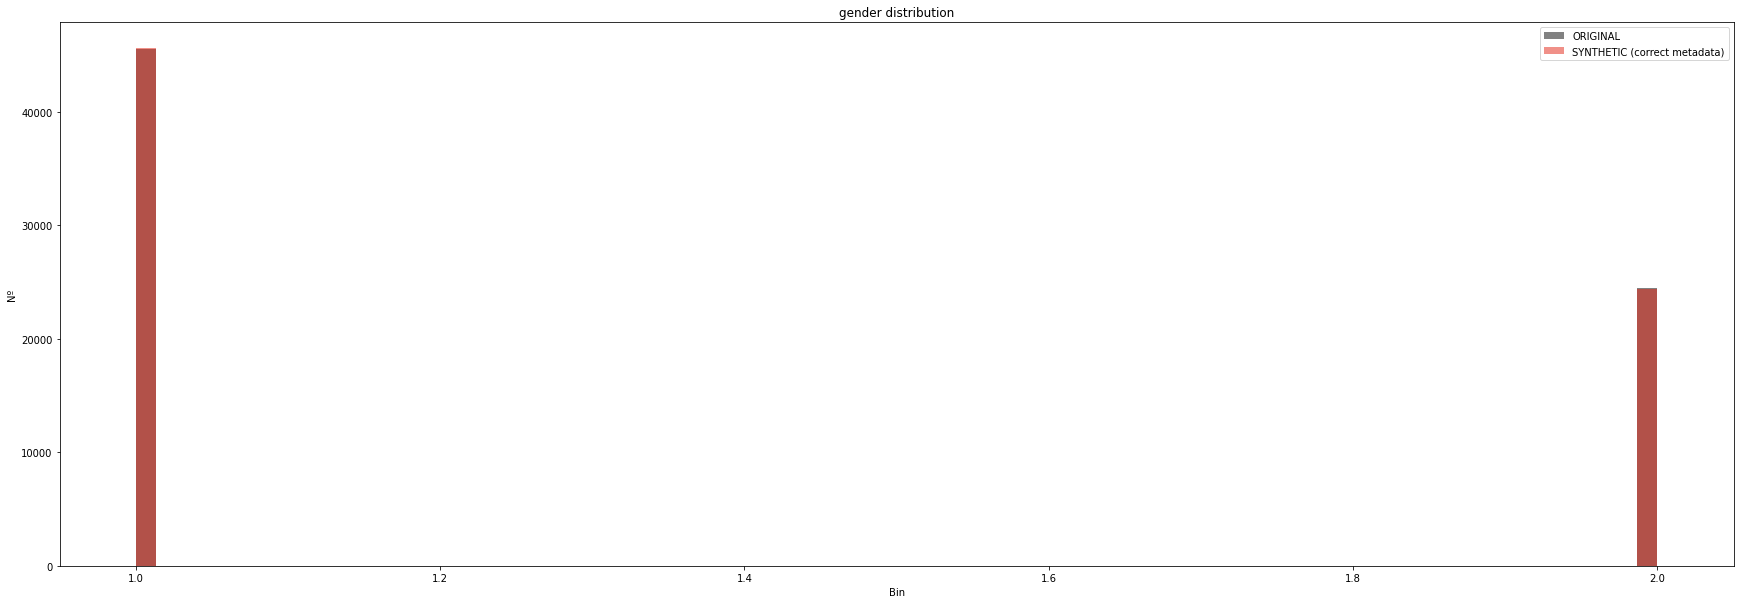

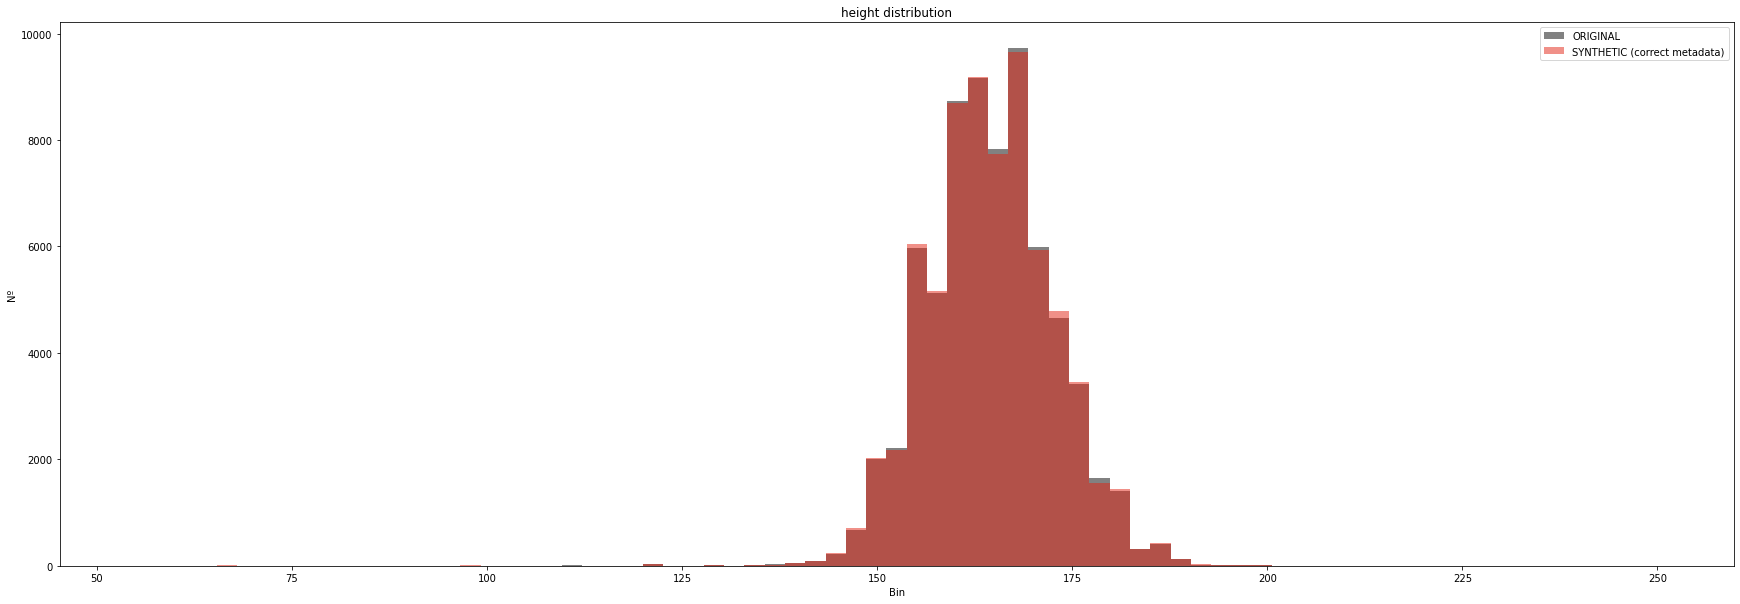

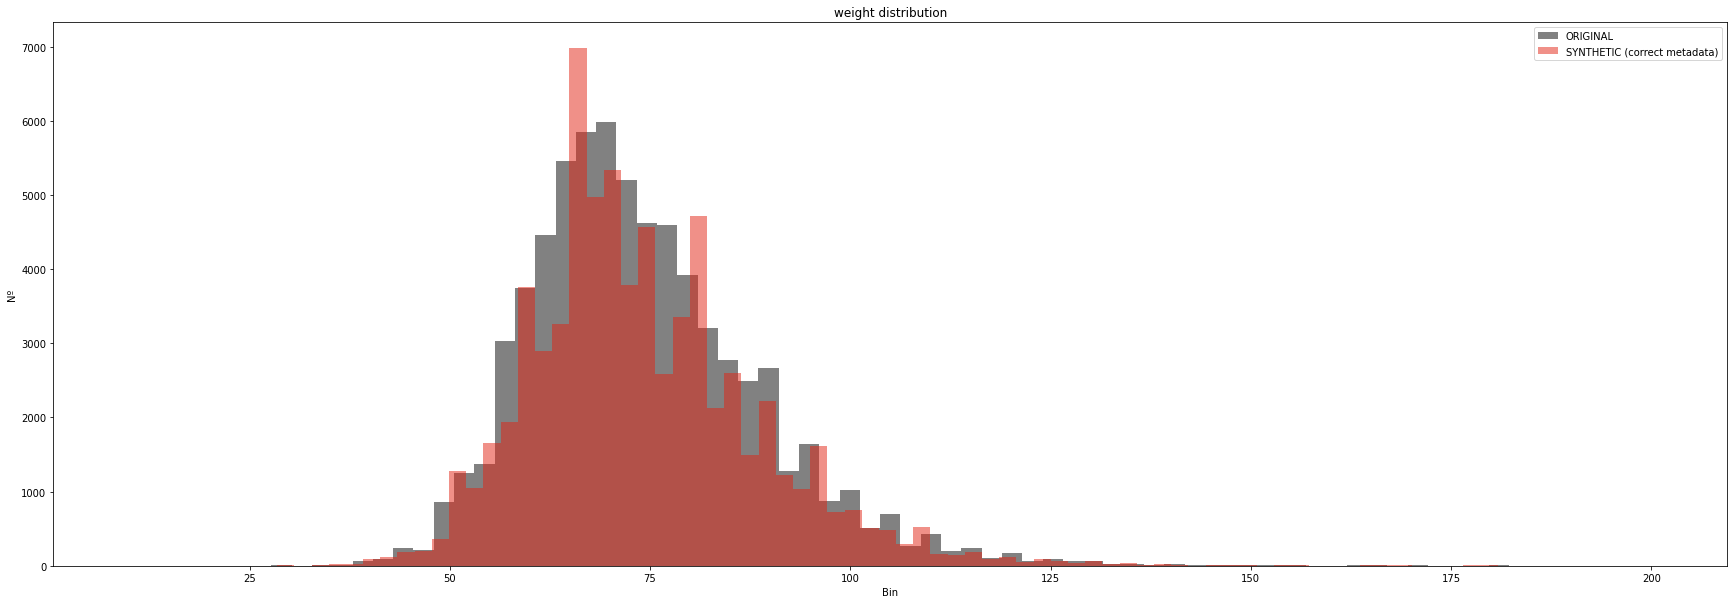

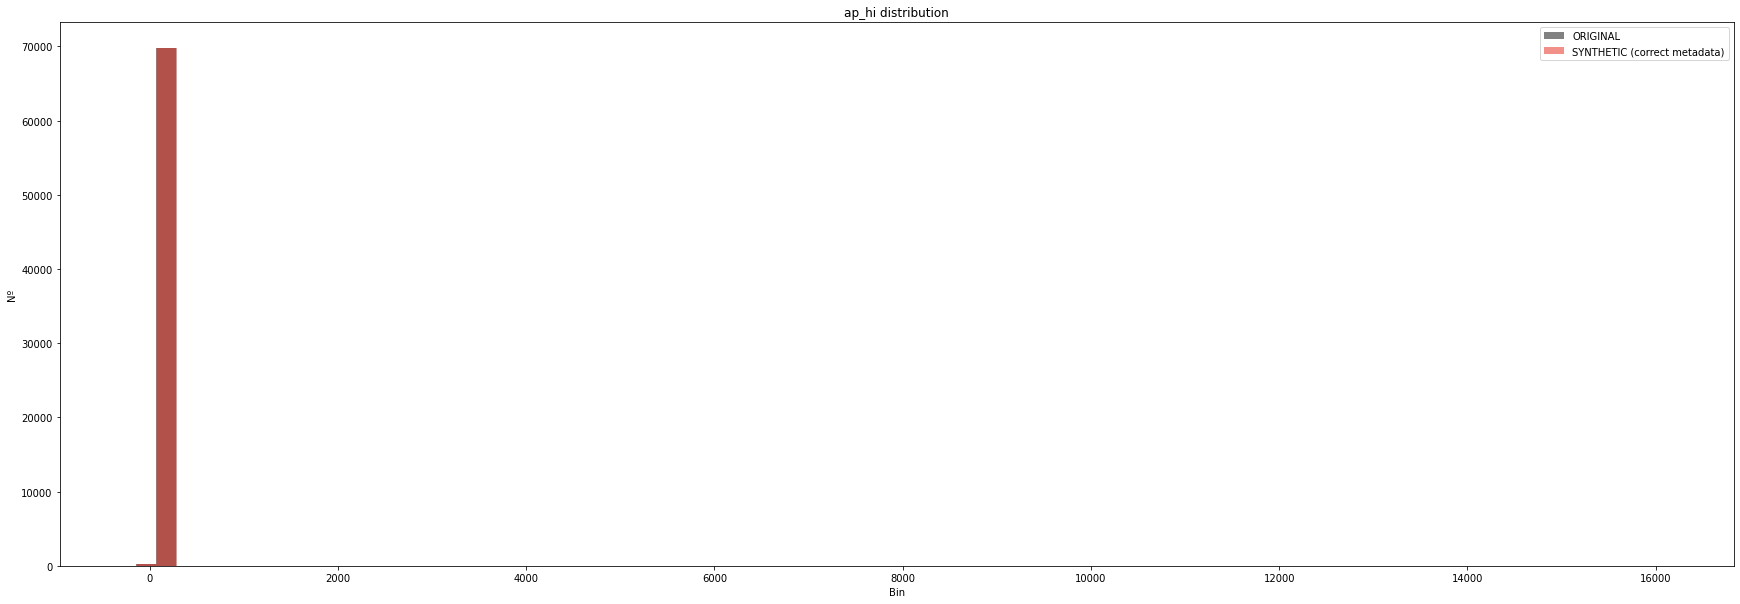

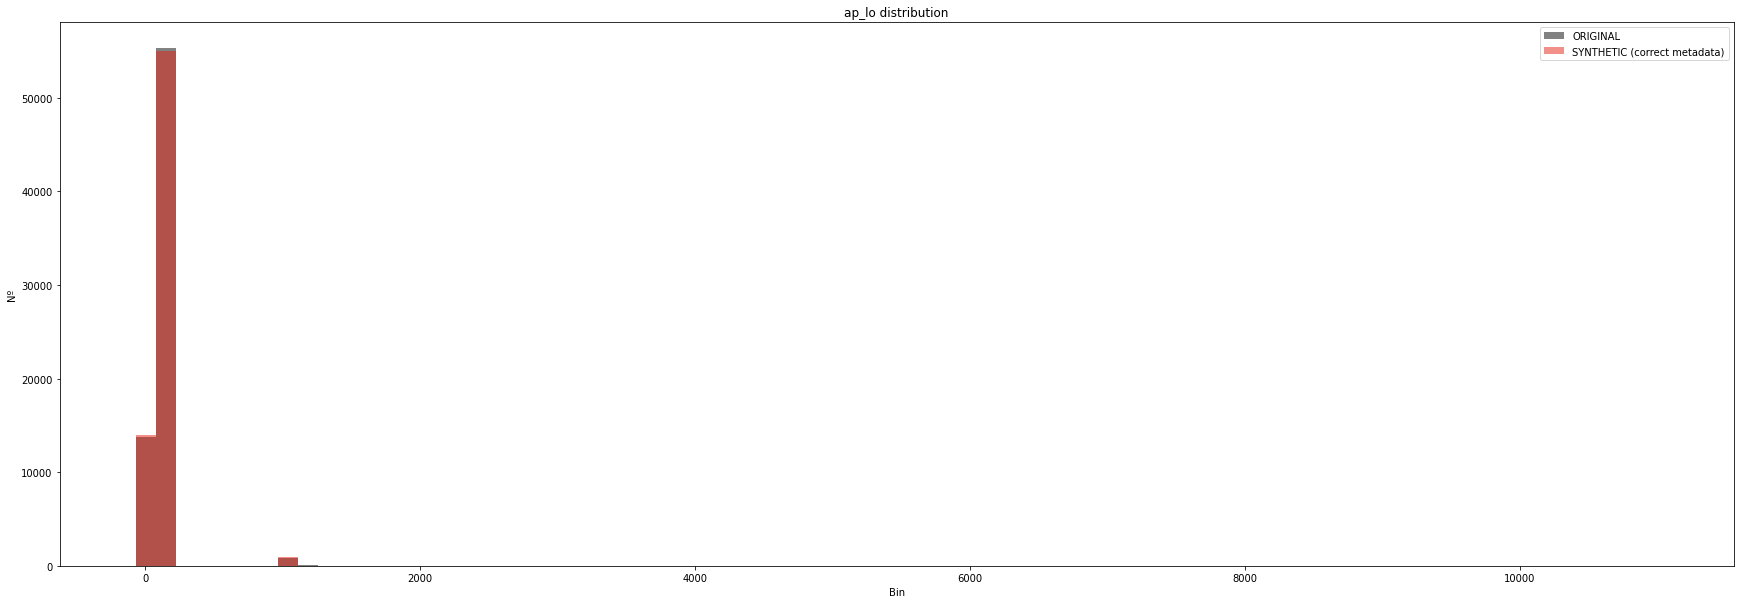

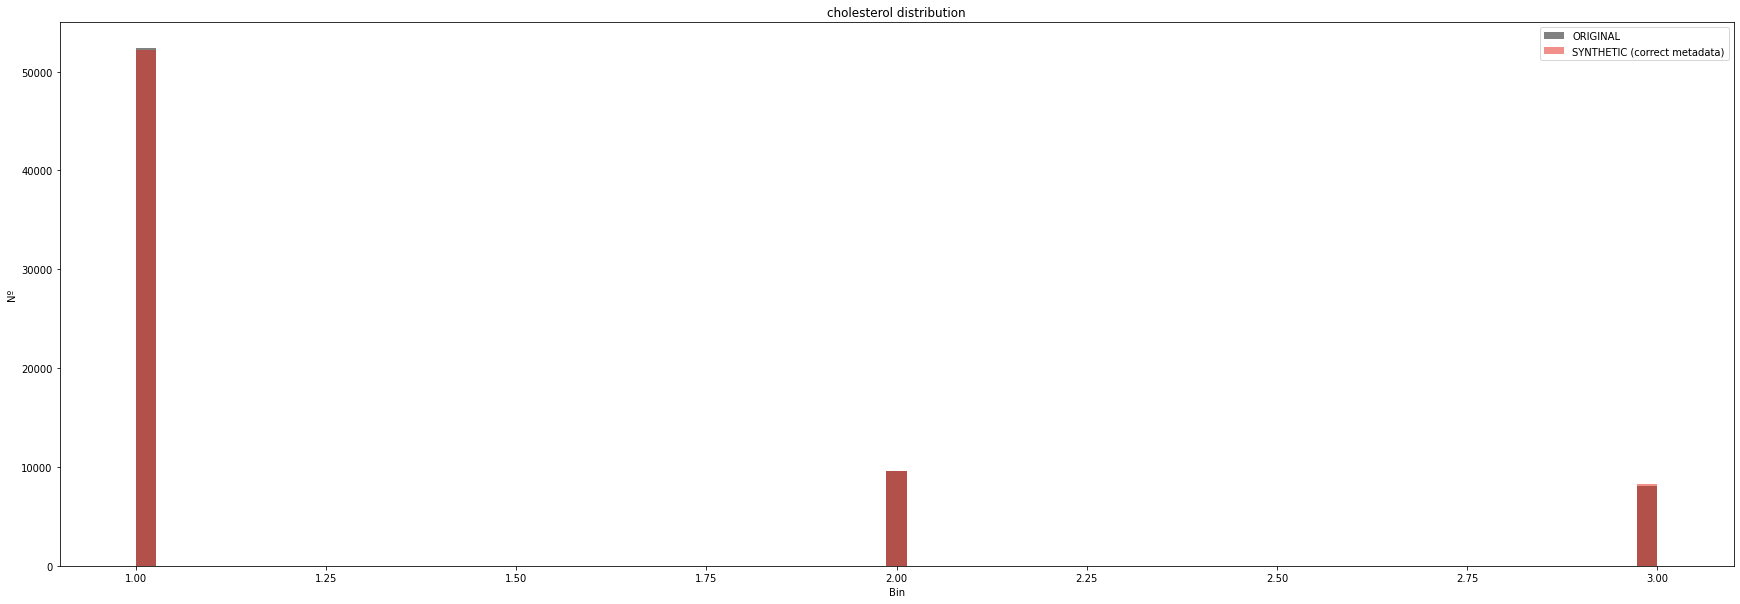

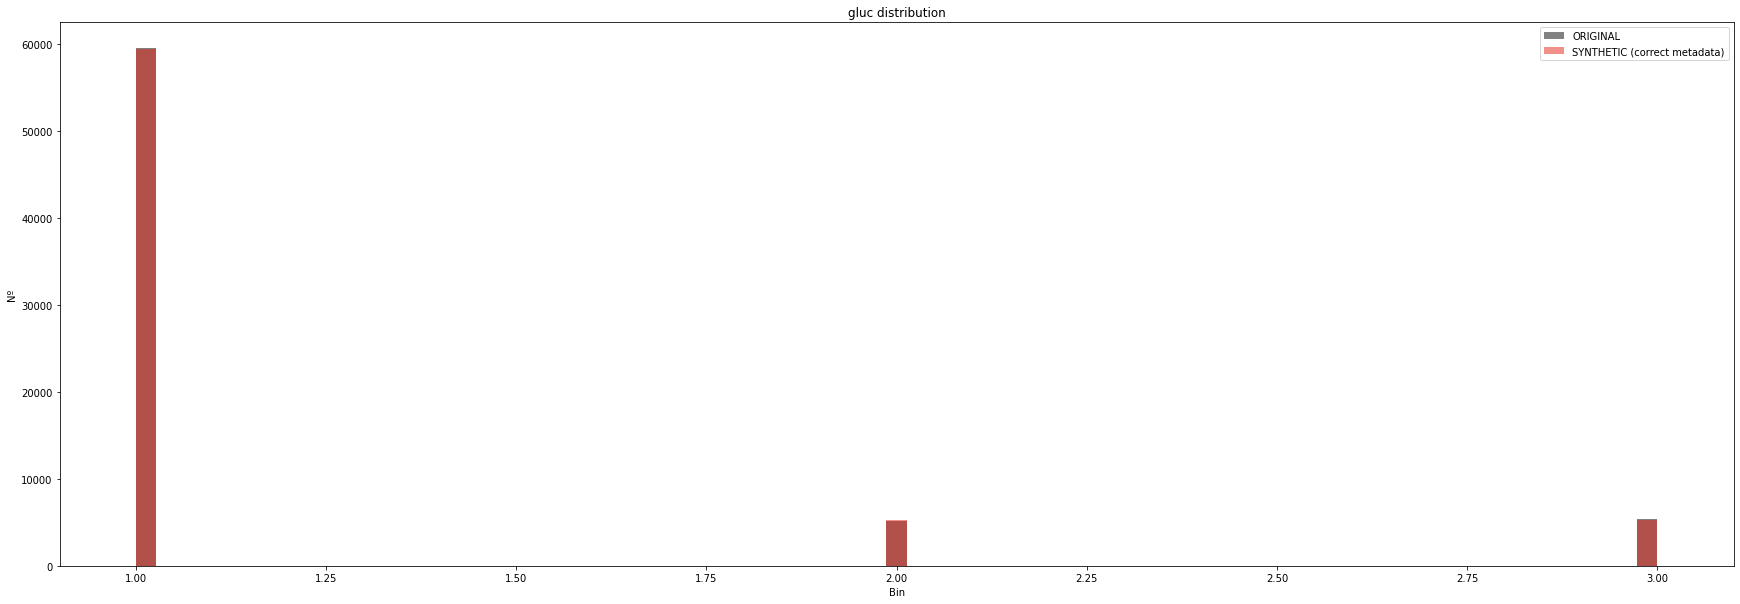

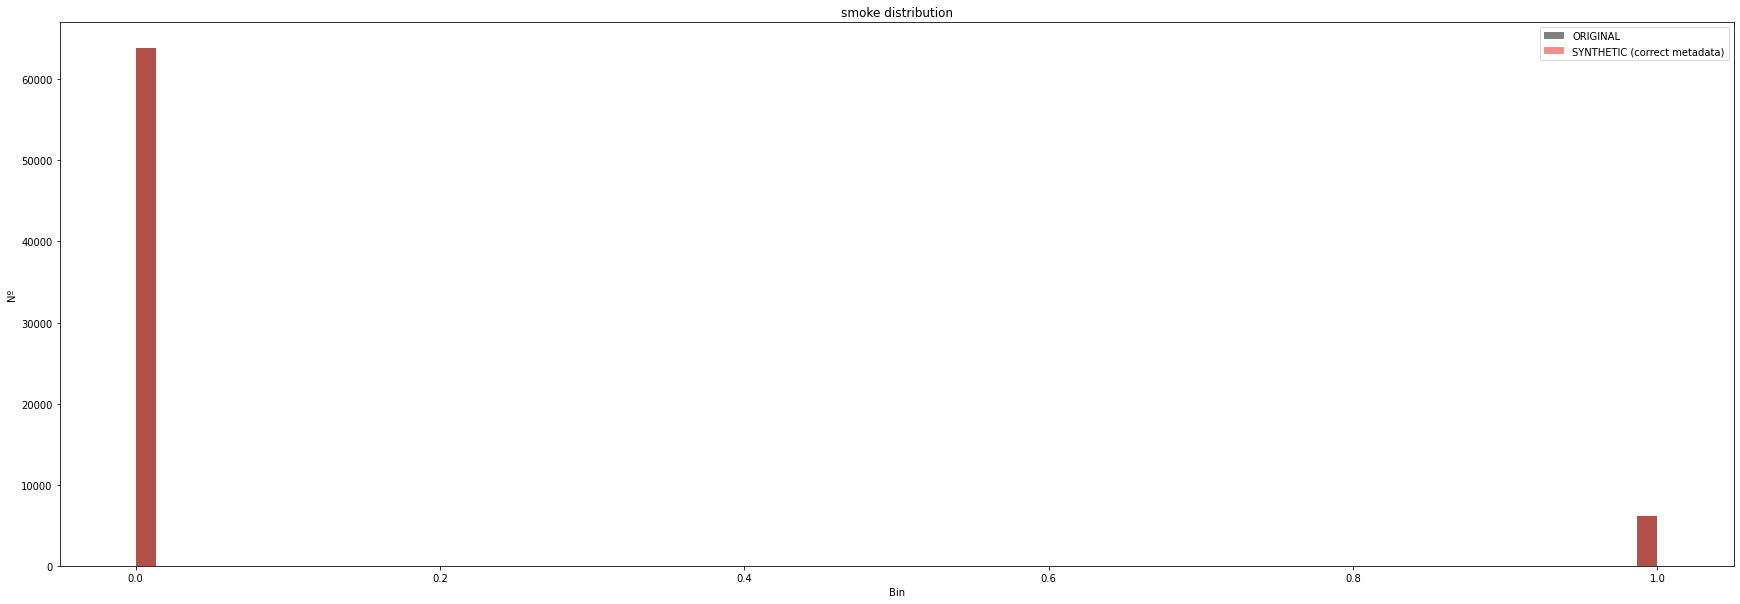

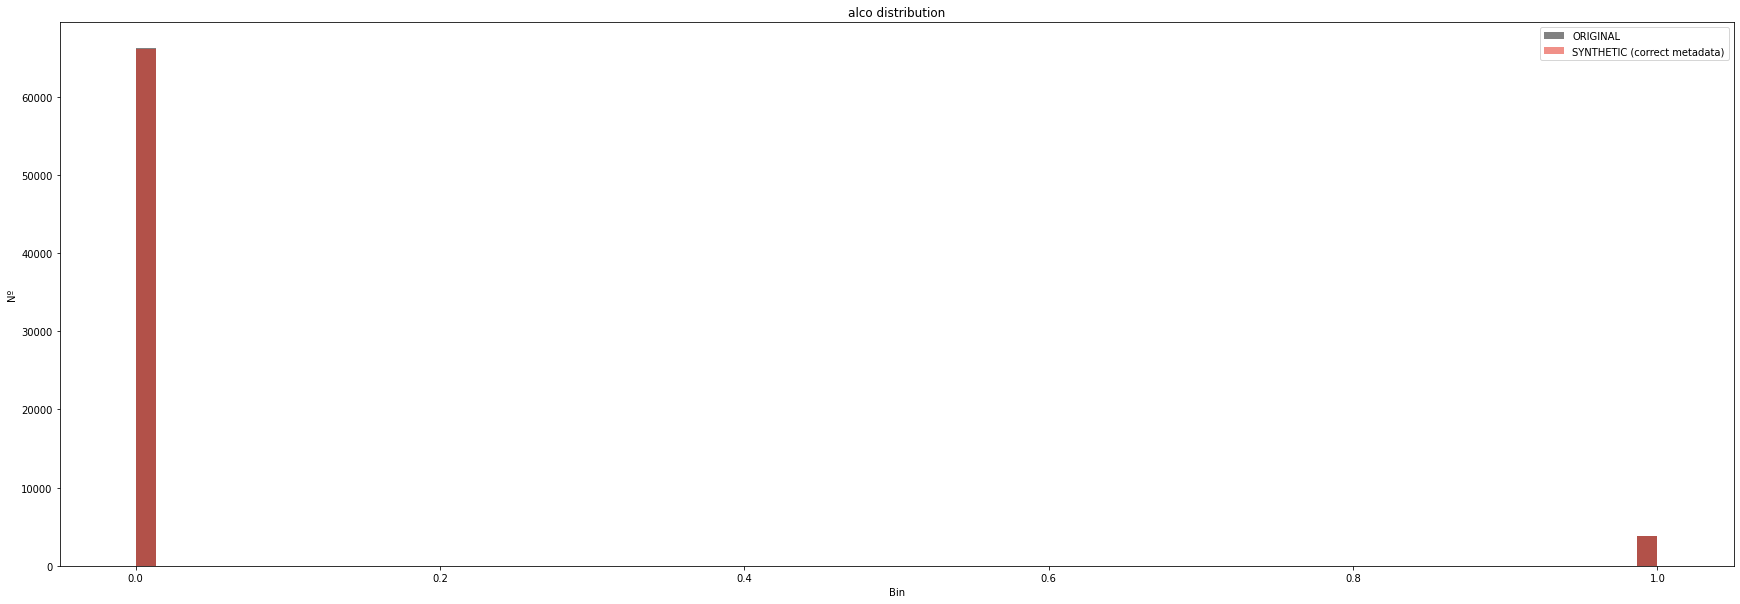

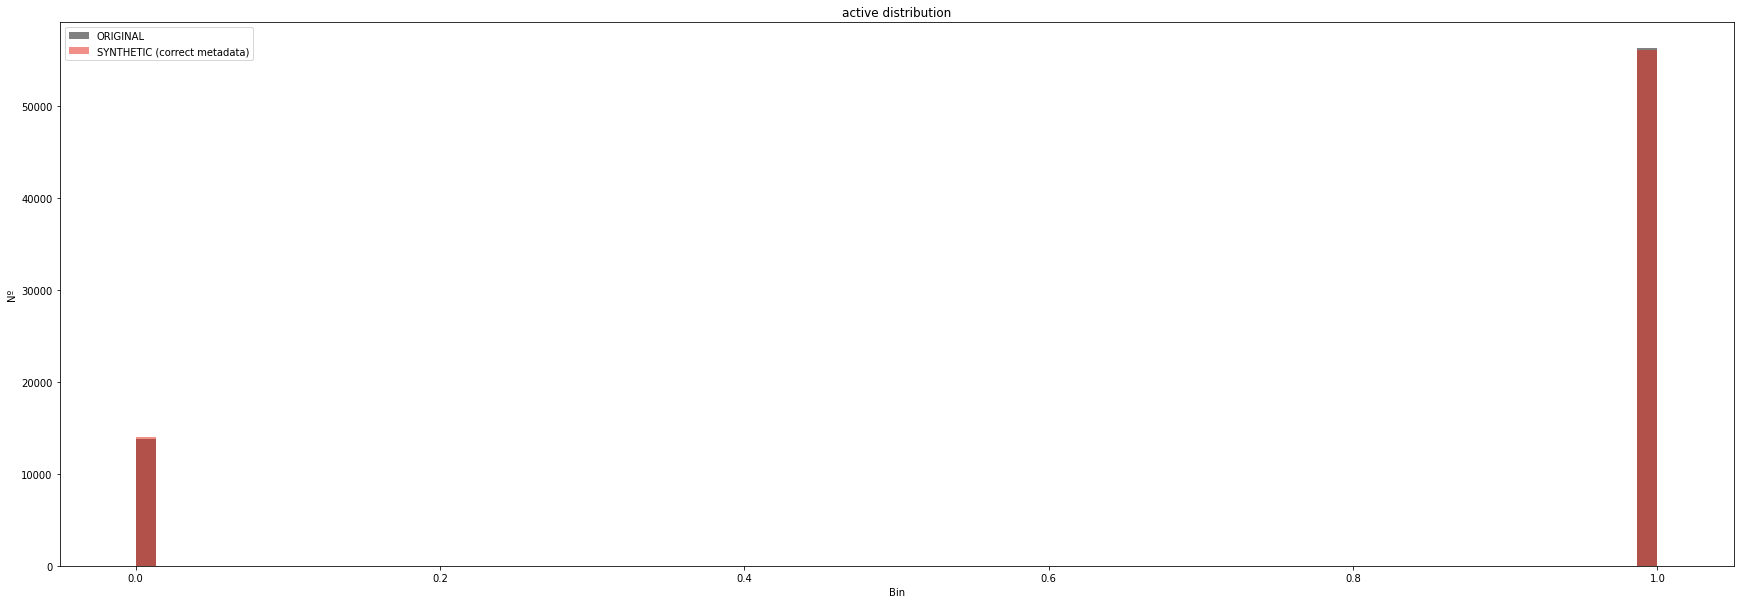

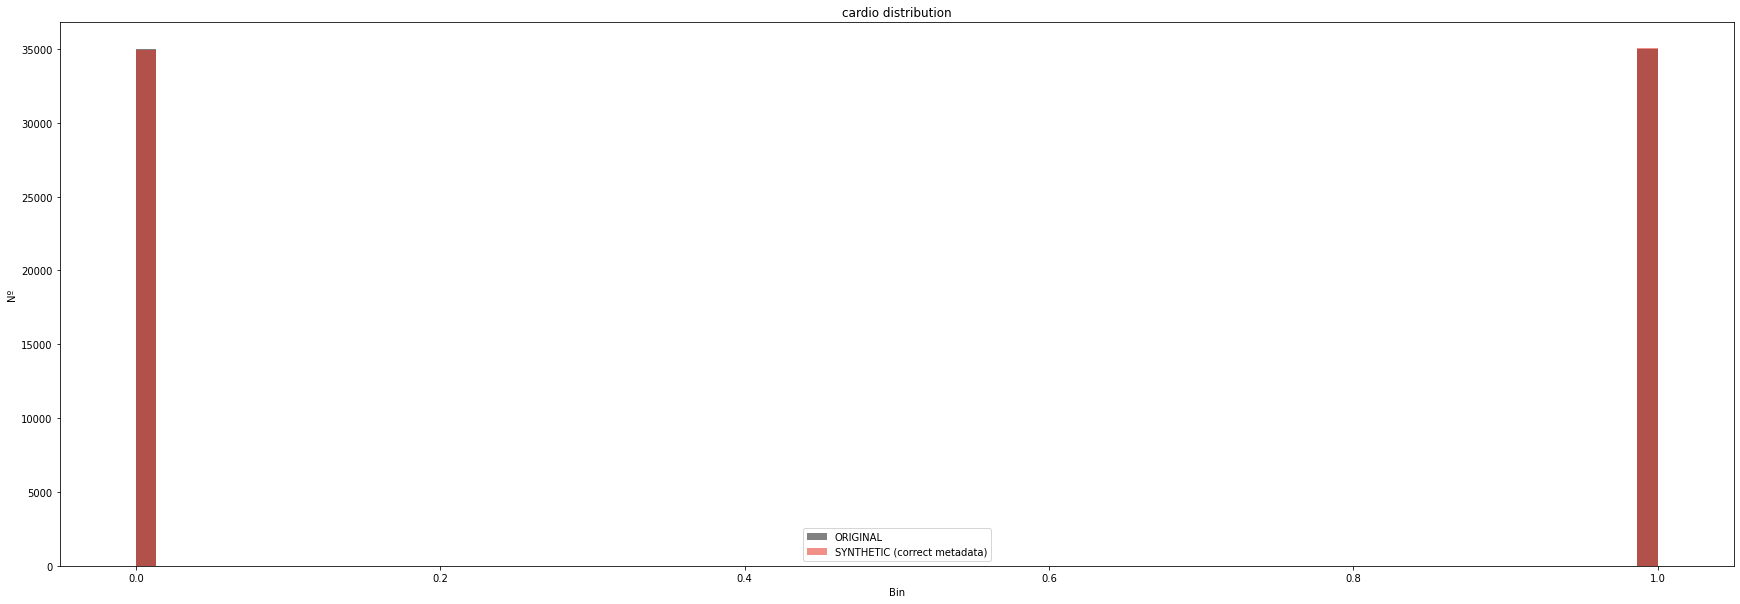

In [31]:
for c in sample_1_df.columns:
    plt.figure(figsize=[30, 10])
    plt.title(f"{c} distribution")
    original_df[c].hist(color="#040404", label="ORIGINAL", grid=False, bins=75, alpha=0.5)
    sample_2_df[c].hist(color="#E32212", label="SYNTHETIC (correct metadata)", grid=False, bins=75, alpha=0.5)
    plt.xlabel("Bin")
    plt.ylabel("Nº")
    plt.legend()
    plt.show()

## Partially joint marginals

While the marginal distributions are important, they are not telling how much we preserve the joint distribution.
Of course, for high dimensional data it is not possible to visualize the joint distribution. For this reason, in the report, we run a dimensionality reduction to observe the most important axis.

Another possibility that we demonstrate here, is the partially joint distribution. We plot the contour plot for each pair of variables.
For the sake of readability, we selected only the columns for which we observe a difference between the two metadata object. We also added the target and id.

We observe some deviation in the contour plot, especially between (age, height) and (height, weight) joint distributions. Of course, as this dataset is relatively simple and the error in the identification of data/variable type were minor, the impact on the fidelity is rather limited. However, one can imagine that if the data/variable types are off for more complex variables, the individual marginal might not be properly replicated, which might in turn affect the joint distribution.

In [25]:
!pip install corner
import corner

In [26]:
cols = ['id', 'age', 'height', 'weight', 'cardio']

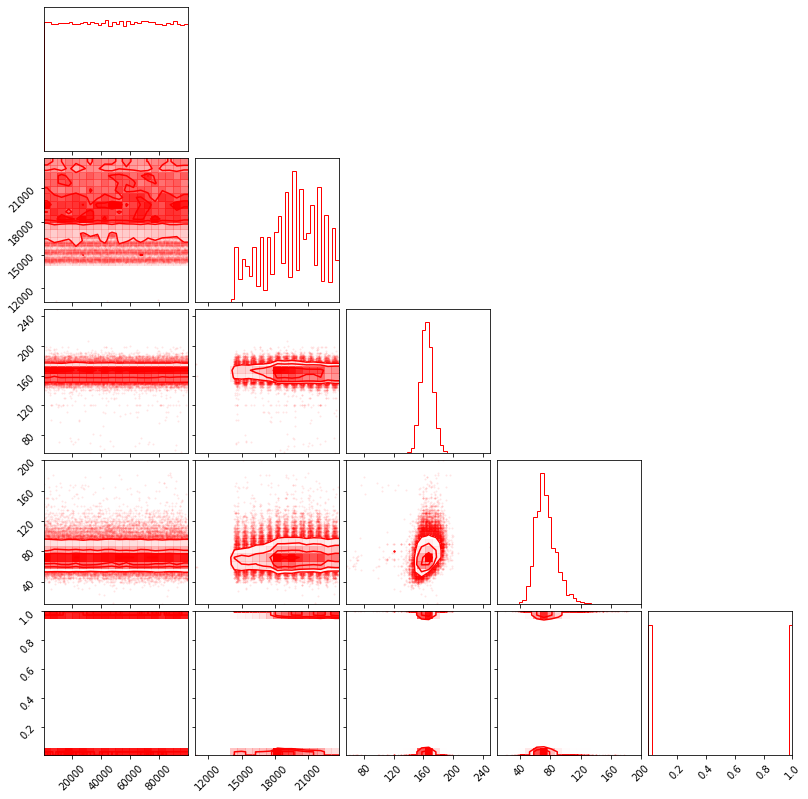

In [27]:
fig = corner.corner(np.array(original_df[cols]), color="red", hist_bin_factor=2)
plt.show()

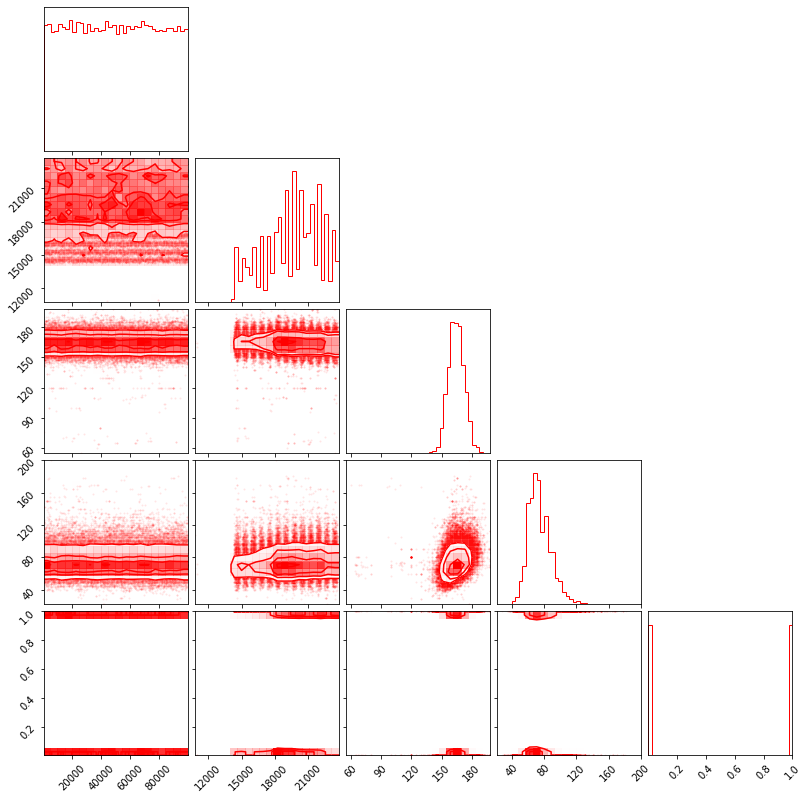

In [28]:
fig = corner.corner(np.array(sample_1_df[cols]), color="red", hist_bin_factor=2)
plt.show()

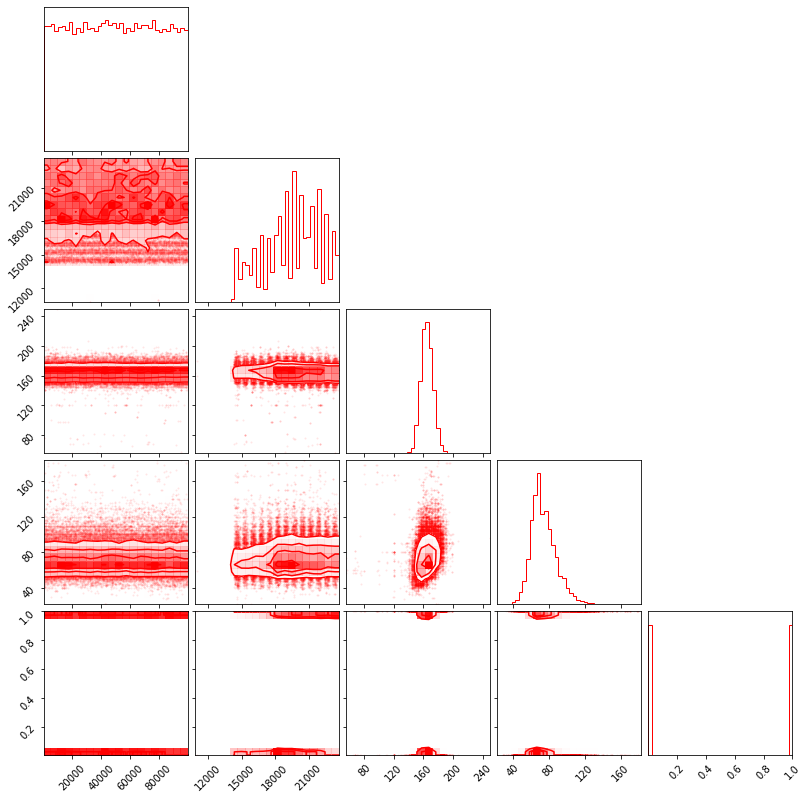

In [29]:
fig = corner.corner(np.array(sample_2_df[cols]), color="red", hist_bin_factor=2)
plt.show()